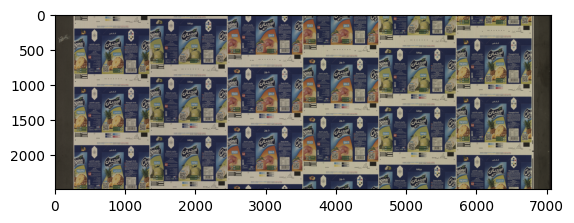

In [11]:
import cv2
from matplotlib import pyplot as plt

path = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/Job1.bmp'
im = cv2.imread(path)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
plt.show()

In [2]:
import fitz
import os
 
def pdf_to_jpg(pdf_path, output_folder, zoom_x=2.0, zoom_y=2.0):
    pdf_document = fitz.open(pdf_path)
 
    # Create a zoom matrix to increase resolution
    mat = fitz.Matrix(zoom_x, zoom_y)
 
    for page_number in range(pdf_document.page_count):
        page = pdf_document[page_number]
        image = page.get_pixmap(matrix=mat)  # apply the zoom matrix
 
        jpg_filename = os.path.join(output_folder, f'page_{page_number + 3}.jpg')
        image.save(jpg_filename)
 
    pdf_document.close()

# Usage example
pdf_path = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples/SA-A073.pdf'  # Replace 'input.pdf' with the path to your PDF file
output_folder = '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images'  # Output folder where JPG images will be saved
os.makedirs(output_folder, exist_ok=True)

pdf_to_jpg(pdf_path, output_folder)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 9.7 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import pytesseract

In [14]:
def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    return (rects, confidences)

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")


In [5]:
import pytesseract

Extracted ID: SA-AQ73-15-P2746 SA-AQ73-25-B0083 |
Corrected ID: SA-A073


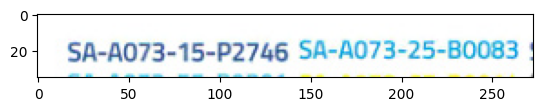

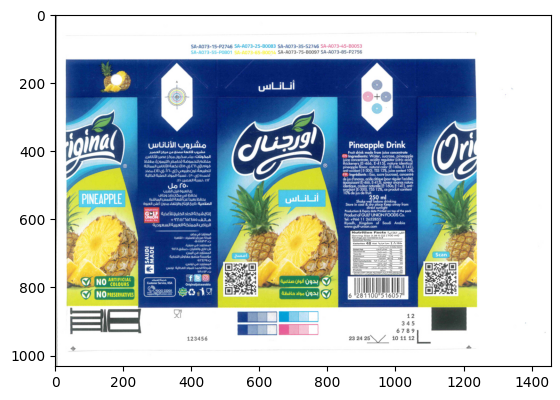

In [15]:
import cv2
import numpy as np

# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# Load the image
image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images/page_3.jpg')
image1 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
orig = image.copy()
(h, w) = image.shape[:2]

# Set the new width and height and determine the ratio in change for both
(newW, newH) = (320, 320)
rW = w / float(newW)
rH = h / float(newH)

# Resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(h, w) = image.shape[:2]

# Define the two output layer names for the EAST detector model
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# Convert the image to a blob and perform forward pass to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Decode the predictions
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

padding = 10  # for example
# Extract the top-most bounding box
if len(boxes) > 0:
    boxes = sorted(boxes, key=lambda r:r[1])
    top_box = boxes[0]
    startX, startY, endX, endY = top_box
    roi = orig[int(startY*rH):int(endY*rH), int(startX*rW):int(endX*rW)]
    extracted_id = pytesseract.image_to_string(roi, config='--psm 6').strip()
    print("Extracted ID:", extracted_id)
    
    import re
    # Regular expression pattern
    pattern = r"[A-Z]{2}-[A-Z][OQ\d]{3}"
    # Find matches in the extracted_id
    matched_ids = re.findall(pattern, extracted_id)

    # Process the matched IDs
    corrected_ids = []
    for id_ in matched_ids:
        # Replace 'O' or 'Q' with '0' in the last three characters
        corrected_id = id_[:-3] + id_[-3:].replace('O', '0').replace('Q', '0')
        corrected_ids.append(corrected_id)
        
    print("Corrected ID:", corrected_ids[0])
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.show()

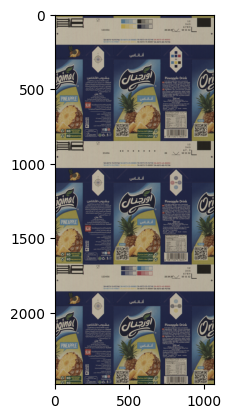

9

In [17]:
def segment_actual_columns(image):
    """
    Segment the actual image columns located between detected borders.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Compute the vertical projection (sum of pixel values along the horizontal axis)
    vertical_projection = np.sum(binary, axis=0)
    
    # Smooth the vertical projection using a 1D Gaussian filter
    smoothed_projection = cv2.GaussianBlur(vertical_projection, (51, 1), 0)
    
    # Set a threshold to segment the columns
    threshold = 0.05 * np.max(smoothed_projection)
    
    # Find the regions where the smoothed projection is less than the threshold
    column_regions = np.where(smoothed_projection < threshold)[0]
    
    # Identify the start and end of each actual column
    column_bounds = []
    prev_boundary = 0
    for boundary in column_regions:
        if boundary - prev_boundary > 1:
            column_bounds.append((prev_boundary, boundary))
        prev_boundary = boundary
    column_bounds.append((prev_boundary, len(smoothed_projection) - 1))
    
    # Extract the actual columns from the image
    actual_columns = [image[:, start:end] for start, end in column_bounds if end - start > 1]
    
    return actual_columns

image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/Job1.bmp')
# Segment the actual columns from the multi-up image
actual_columns = segment_actual_columns(image)

# Display the first actual column for reference
plt.imshow(cv2.cvtColor(actual_columns[1], cv2.COLOR_BGR2RGB))
plt.show()

# Return the number of actual columns
len(actual_columns)


SA-A073


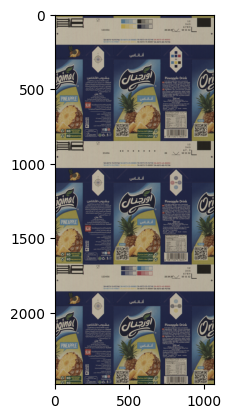

Number of matching columns: 2


In [18]:
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extract_first_id(image, net):
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Adjust the width and height to the nearest multiple of 32
    newW = int(w / 32) * 32
    newH = int(h / 32) * 32    
    rW = w / float(newW)
    rH = h / float(newH)

    # Resize the image
    image = cv2.resize(image, (newW, newH))
    (h, w) = image.shape[:2]

    # Define the two output layer names for the EAST detector model
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # Convert the image to a blob and perform forward pass
    blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (rects, confidences) = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    
    import re
    # Regular expression pattern
    pattern = r"[A-Z]{2}-[A-Z][OQ\d]{3}"
    
    # Iterate through all detected bounding boxes
    for box in boxes:
        startX, startY, endX, endY = box
        startX = max(0, startX)
        startY = max(0, startY)
        endX = min(orig.shape[1], endX)
        endY = min(orig.shape[0], endY)
        roi = orig[int(startY*rH):int(endY*rH), int(startX*rW):int(endX*rW)]
        extracted_text = pytesseract.image_to_string(roi, config='--psm 6').strip()
        
        # Find matches in the extracted_text
        matched_ids = re.findall(pattern, extracted_text)

        # Process the matched IDs
        for id_ in matched_ids:
            corrected_id = id_[:-3] + id_[-3:].replace('O', '0').replace('Q', '0')
            if corrected_id:  # If a valid ID is found, return it
                return corrected_id

    # If no valid ID is found in any text region
    return None


# Load the pre-trained EAST model
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

print(corrected_ids[0])
reference_id = corrected_ids[0]

# Segment the actual columns from the multi-up image
image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/Job1.bmp')
actual_columns = segment_actual_columns(image)

matching_columns = []
for column in actual_columns:
    if column.shape[1] < 270:  
        continue
    column_id = extract_first_id(column, net)
    if column_id == reference_id:
        matching_columns.append(column)

# Display the first matching column for reference
if matching_columns:
    plt.imshow(cv2.cvtColor(matching_columns[0], cv2.COLOR_BGR2RGB))
    plt.show()

# Return the number of matching columns
print(f"Number of matching columns: {len(matching_columns)}")

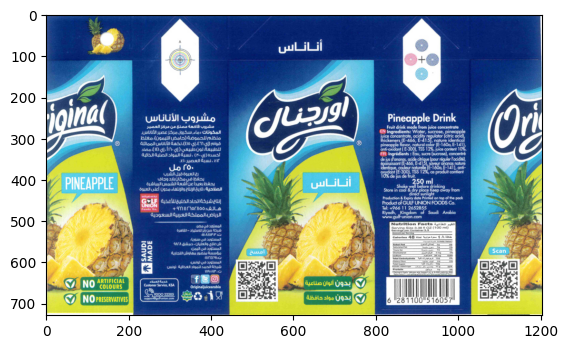

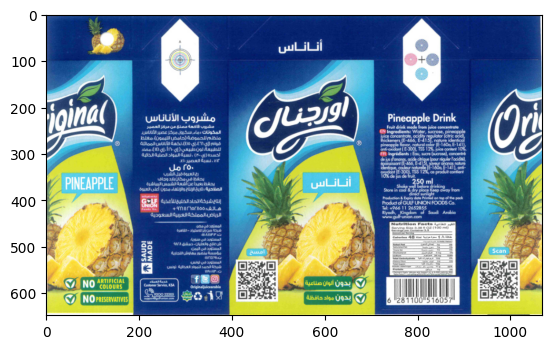

SSIM Score: 0.5665454783923313
MSE Score: 3390.0585250435965


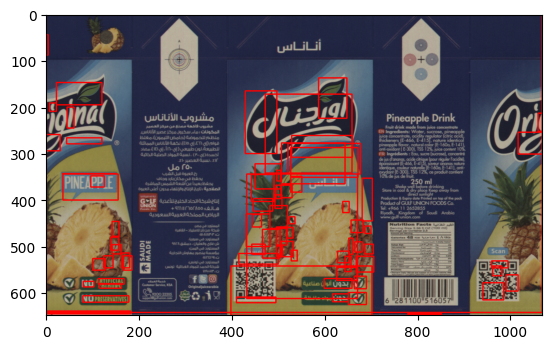

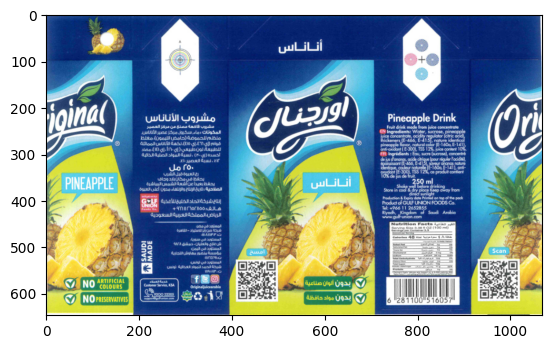

SSIM Score: 0.5633492468068846
MSE Score: 3465.853477878038


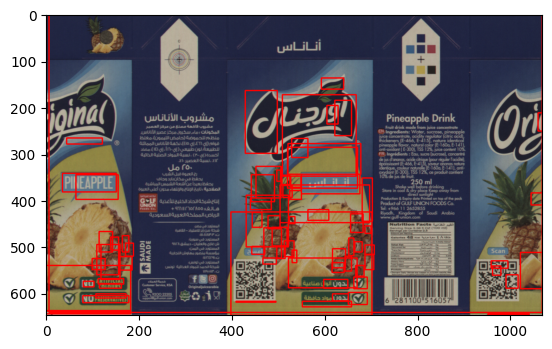

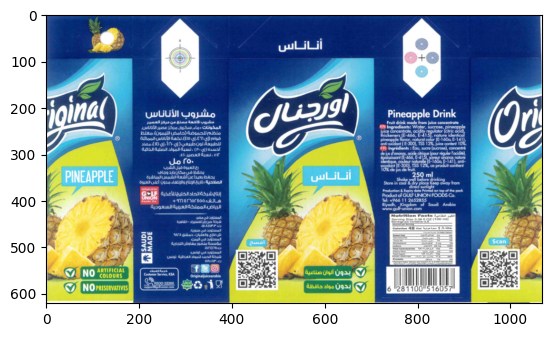

SSIM Score: 0.378205035627378
MSE Score: 4922.788933929252


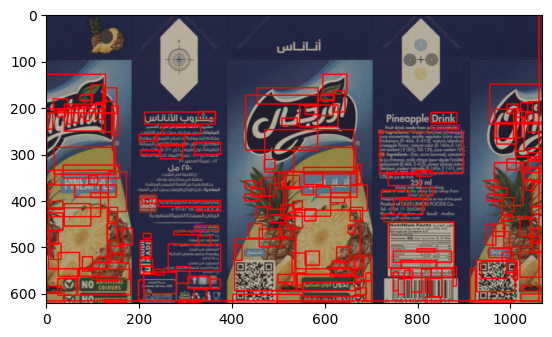

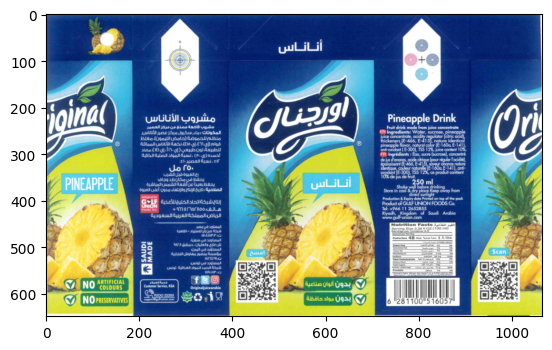

SSIM Score: 0.5293586402369801
MSE Score: 3515.728332229986


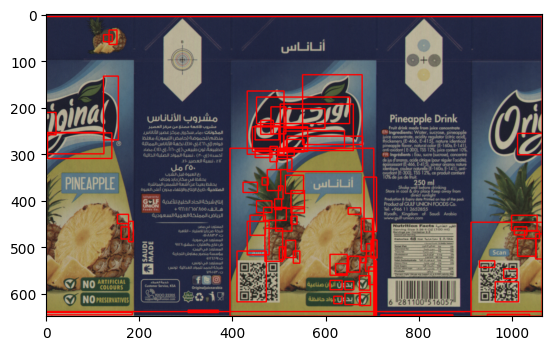

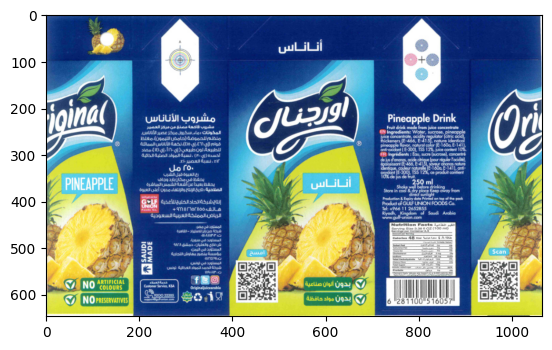

SSIM Score: 0.5236777554443007
MSE Score: 3549.3663843225045


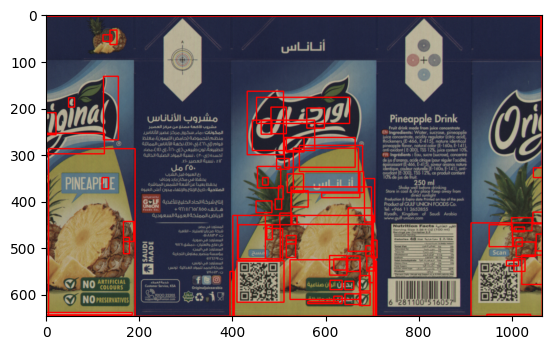

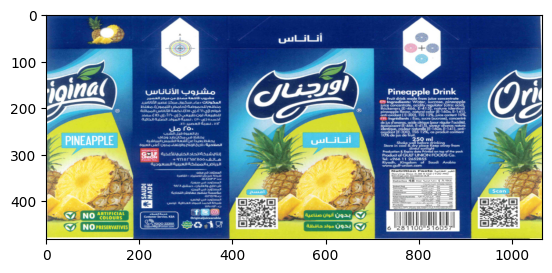

SSIM Score: 0.3091074389272583
MSE Score: 6792.325451721641


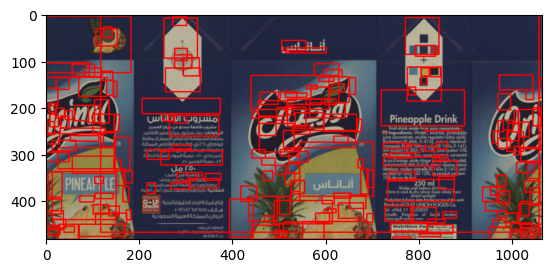

In [35]:
def crop_to_content(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are detected, return the original image
    if not contours:
        return image

    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image to this bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    return cropped_image

import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

def compare_images(imageA, imageB):
    # Convert images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between two images
    score, diff = ssim(grayA, grayB, full=True)
    print(f"SSIM Score: {score}")

    # Compute MSE
    mse_score = mse(grayA, grayB)
    print(f"MSE Score: {mse_score}")

    # If you want to use the absolute difference
    # diff = cv2.absdiff(grayA, grayB)

    diff = (diff * 255).astype("uint8")

    # Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Make a copy of the test image to draw on
    defects = imageB.copy()

    # Loop over the contours
    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Adjust value as needed
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            x, y, w, h = cv2.boundingRect(approx)
            cv2.rectangle(defects, (x, y), (x+w, y+h), (0,0,255), 2)

    return defects


def segment_column_using_contours(column_image):
    gray = cv2.cvtColor(column_image, cv2.COLOR_BGR2GRAY)
    
    # Binarize the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    segmented_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filtering out very small or very large bounding boxes
        if 200 < h < column_image.shape[0] - 50: 
            segmented_image = column_image[y:y+h, x:x+w]
            segmented_images.append(segmented_image)
            
    # Sort the segmented images by their vertical position in the column
    segmented_images = sorted(segmented_images, key=lambda x: -x.shape[0])
    
    return segmented_images

# Test the function on a column image
segmented_imgs_from_first_column = segment_column_using_contours(matching_columns[0])

# def compare_images(imageA, imageB):
#     # Compute the absolute difference between the two images
#     diff = cv2.absdiff(imageA, imageB)
#     return diff

def resize_images_to_match(reference, test):
    # Determine the width and height of both images
    ref_height, ref_width = reference.shape[:2]
    test_height, test_width = test.shape[:2]
    
    # Select the smaller dimensions between the two images
    target_width = min(ref_width, test_width)
    target_height = min(ref_height, test_height)
    
    # Resize both images to the smaller dimensions
    resized_ref = cv2.resize(reference, (target_width, target_height))
    resized_test = cv2.resize(test, (target_width, target_height))
    
    return resized_ref, resized_test

reference_image = cv2.imread('/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/samples_images/page_3.jpg')
reference_image = cv2.rotate(reference_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
cropped_reference = crop_to_content(reference_image)
plt.imshow(cv2.cvtColor(cropped_reference, cv2.COLOR_BGR2RGB))
plt.show()

reference_images = []  # List to store resized reference images
test_images = []  # List to store resized test images
defect_images = []

for column_image in matching_columns:
    segmented_images = segment_column_using_contours(column_image)
    for image in segmented_images:
        cropped_img = crop_to_content(image)
        # Resize the images to match in size
        resized_reference, resized_test = resize_images_to_match(cropped_reference, cropped_img)
        reference_images.append(resized_reference)
        test_images.append(resized_test)
        plt.imshow(cv2.cvtColor(resized_reference, cv2.COLOR_BGR2RGB))
        plt.show()
        # Resize the cropped_img to the size of cropped_reference for comparison
        # resized_cropped_img = cv2.resize(cropped_img, (cropped_reference.shape[1], cropped_reference.shape[0]))
        defects = compare_images(resized_reference, resized_test)
        defect_images.append(defects)
        # Display the defects in color
        plt.imshow(cv2.cvtColor(defects, cv2.COLOR_BGR2RGB))
        plt.show()

    

In [27]:
import cv2
import numpy as np

def calculate_bounding_box_sizes(images):
    sizes = []  # Array to store the sizes of bounding boxes

    for image in images:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Binarize the image
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Calculate the sizes of bounding boxes and store in the sizes array
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            box_size = w * h
            sizes.append(box_size)

    return sizes

# Assuming you have a list of images called test_images
bounding_box_sizes = calculate_bounding_box_sizes(defect_images)

# Print the array of bounding box sizes
print("Bounding Box Sizes:", bounding_box_sizes)

Bounding Box Sizes: [552, 692712, 625, 6, 12, 4, 4, 10, 4, 6, 40, 4, 5005, 55, 380, 361, 24, 691643, 663849, 691834, 689702, 1, 2, 2, 1, 1, 258, 2, 1, 2, 2, 1, 1, 1, 513812]


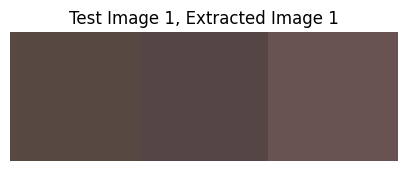

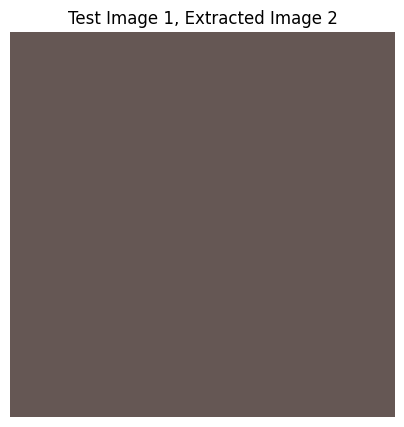

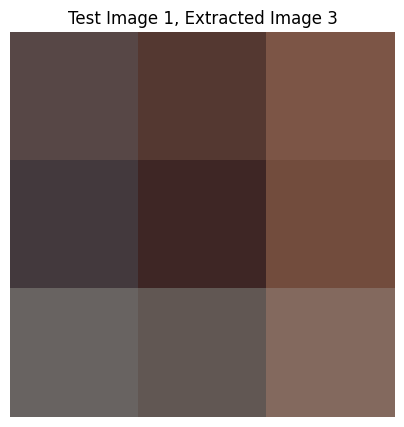

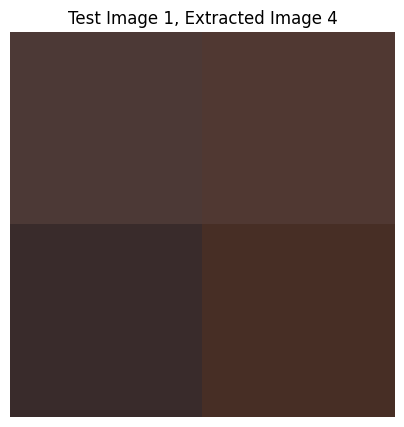

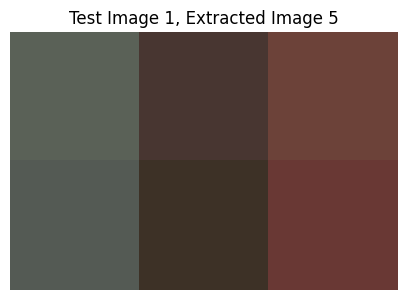

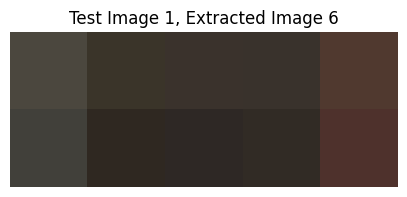

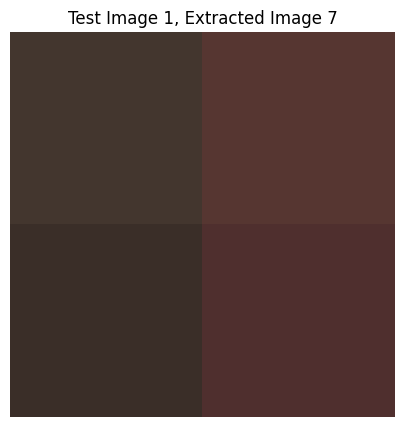

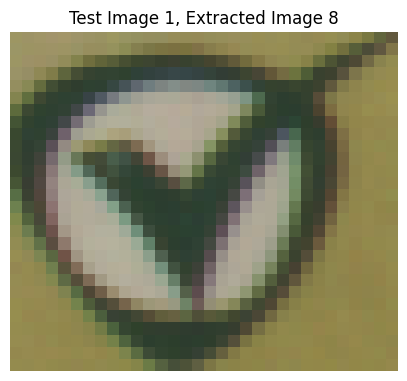

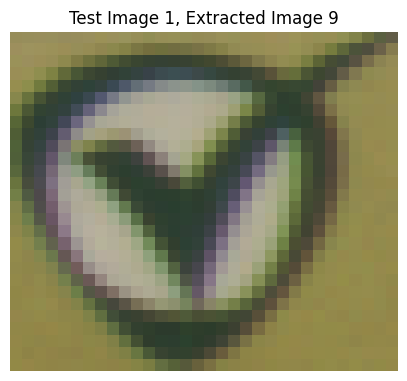

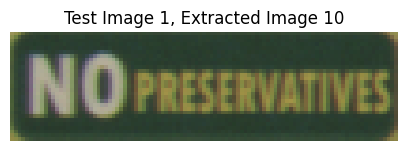

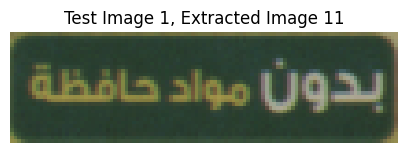

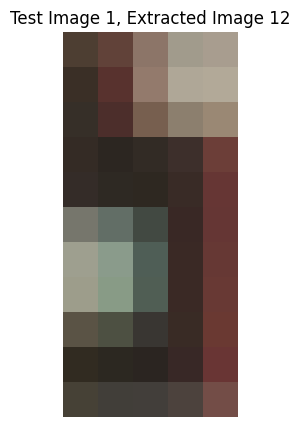

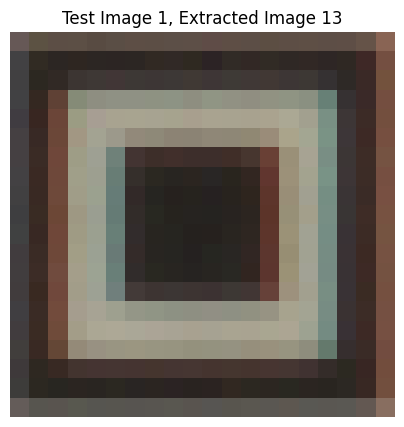

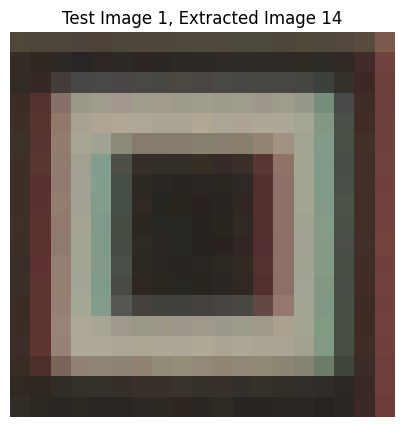

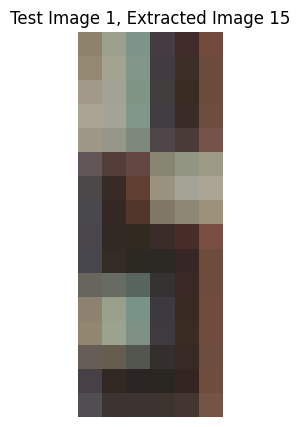

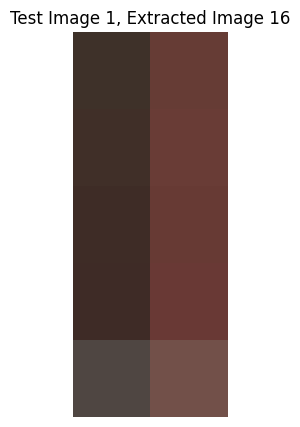

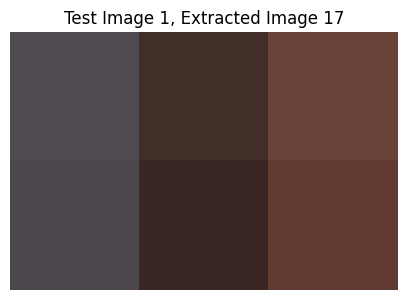

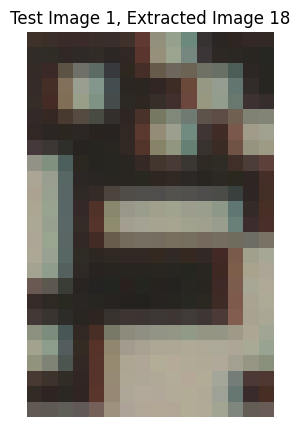

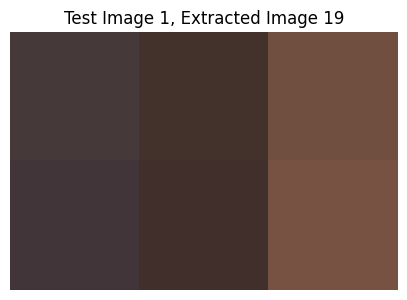

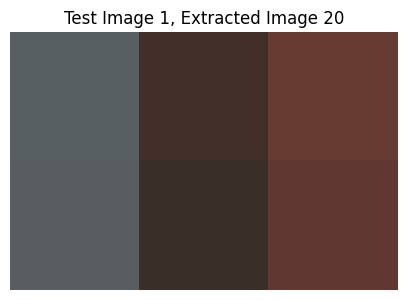

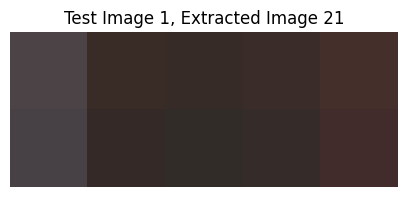

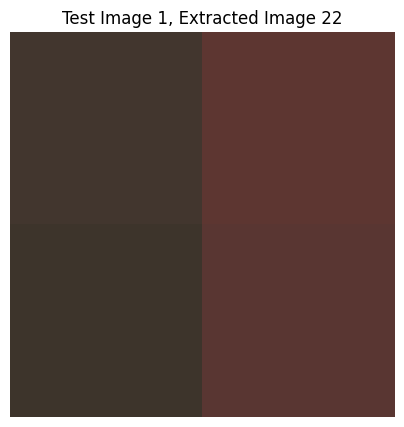

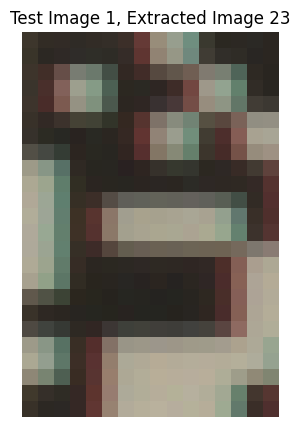

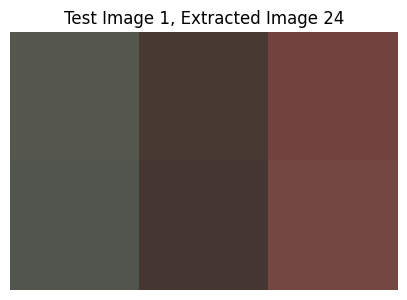

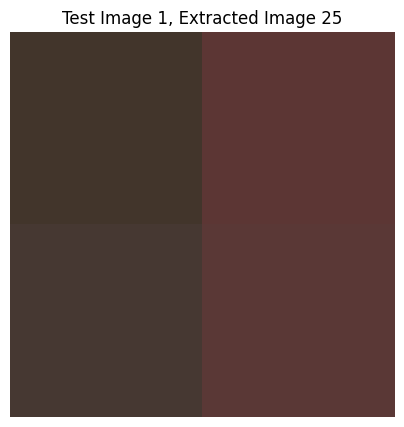

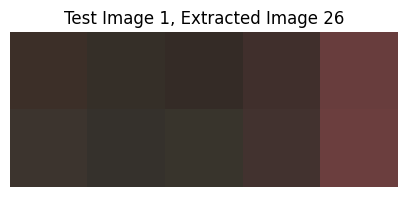

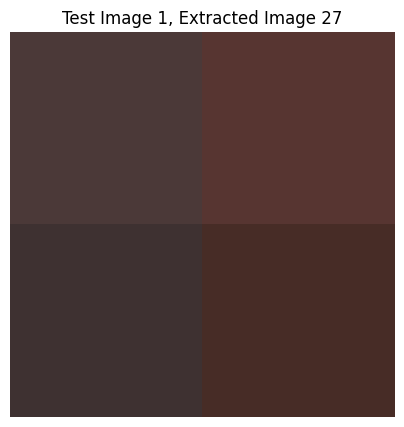

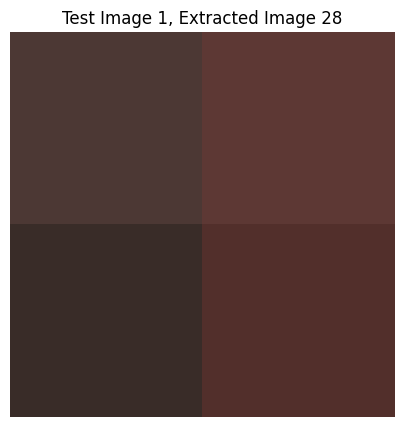

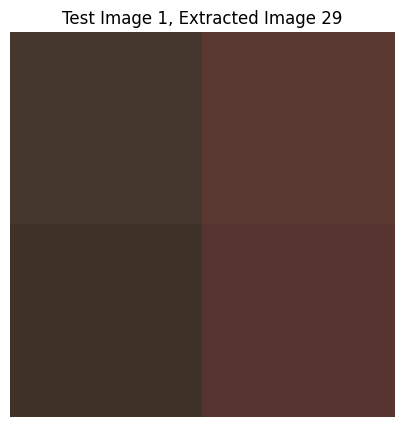

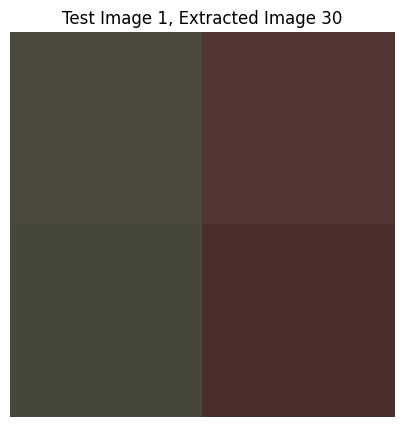

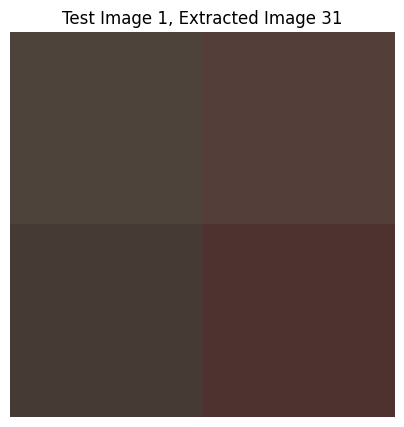

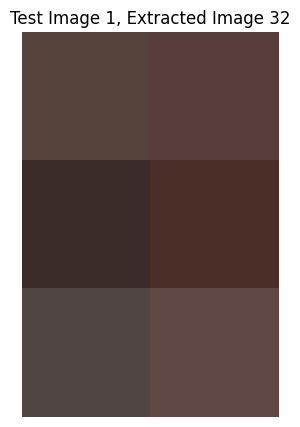

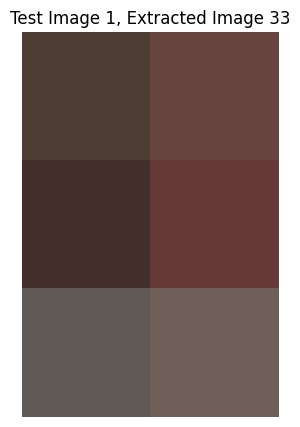

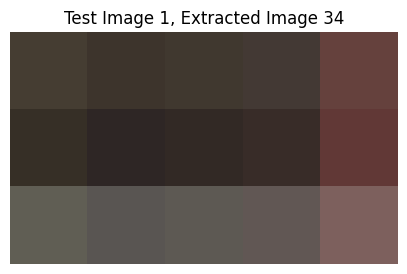

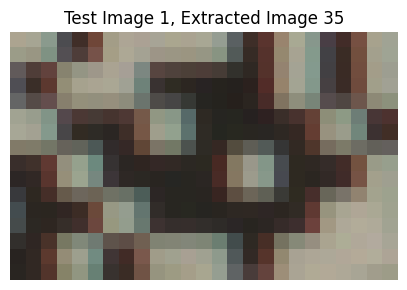

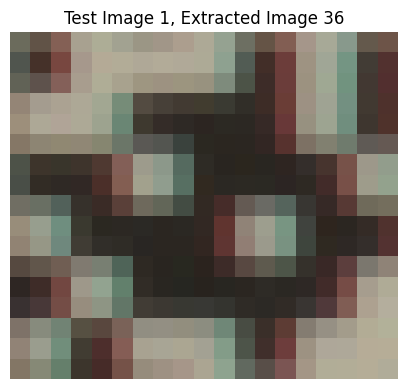

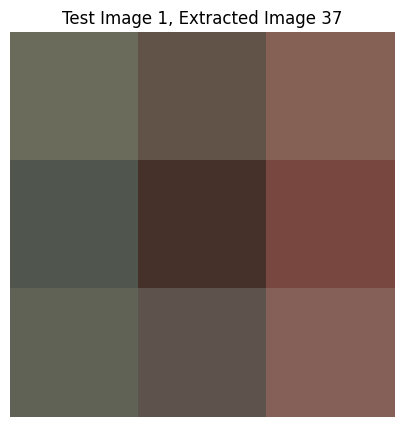

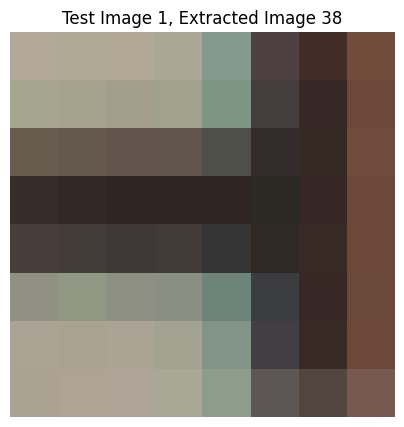

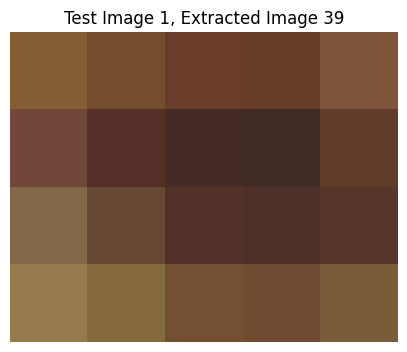

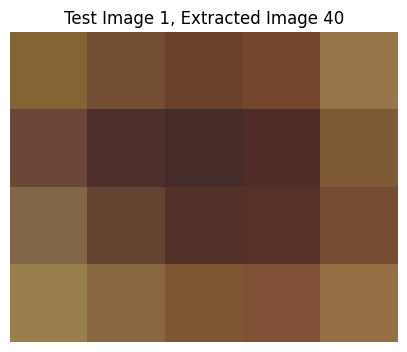

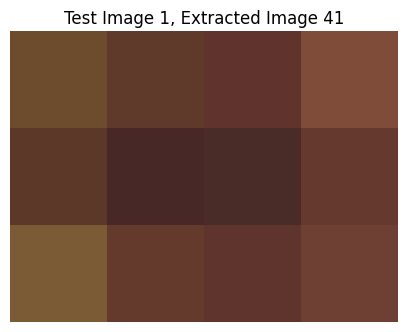

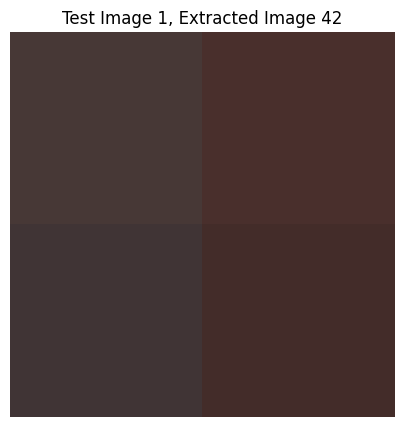

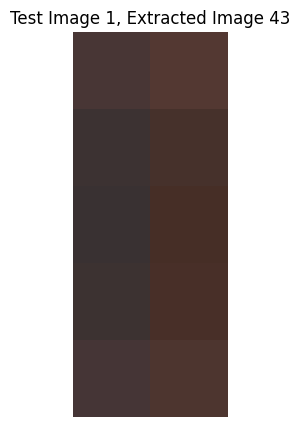

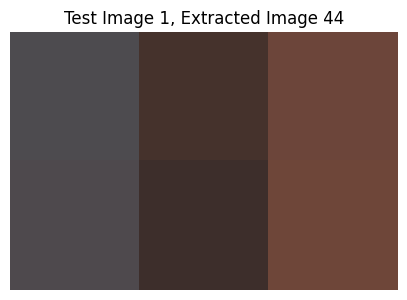

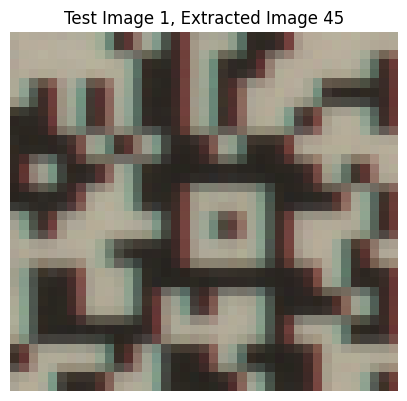

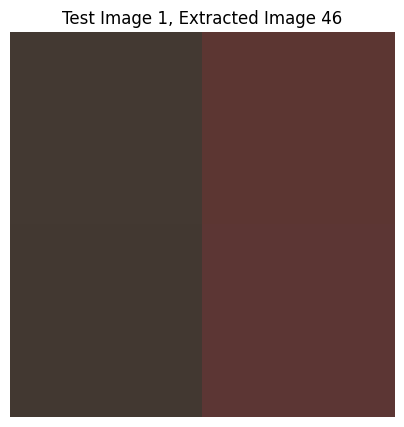

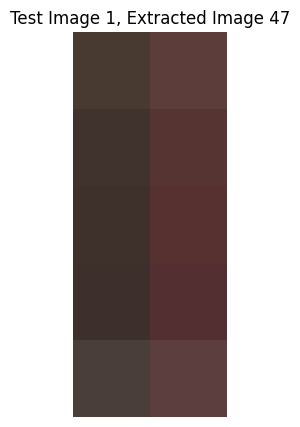

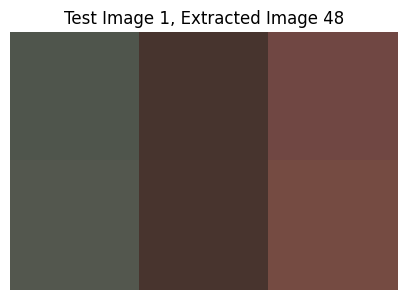

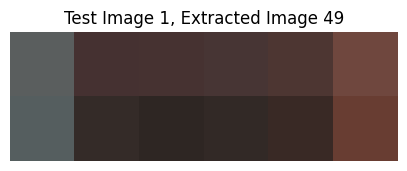

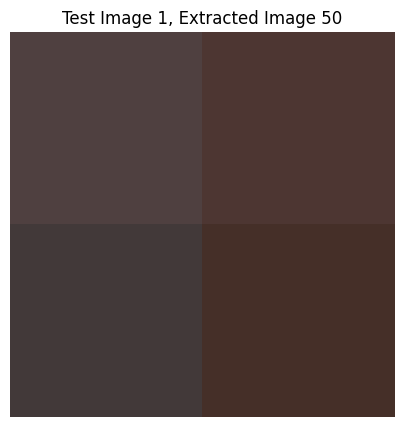

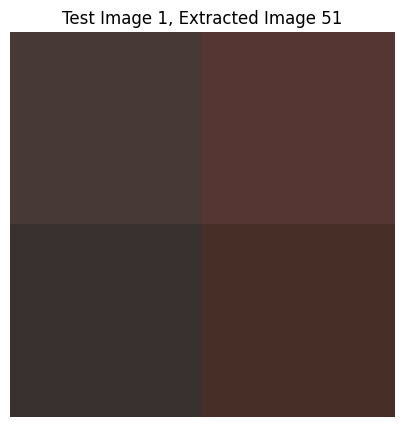

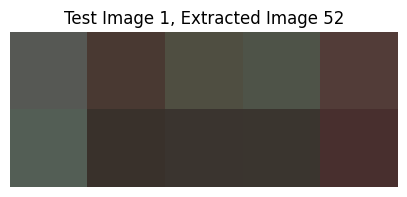

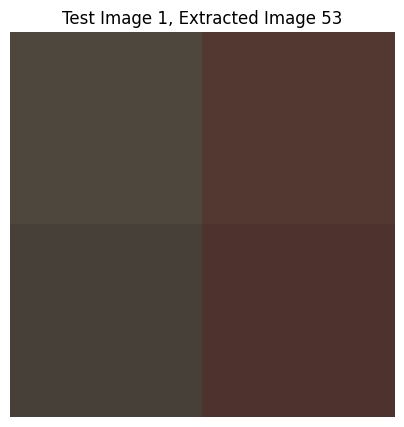

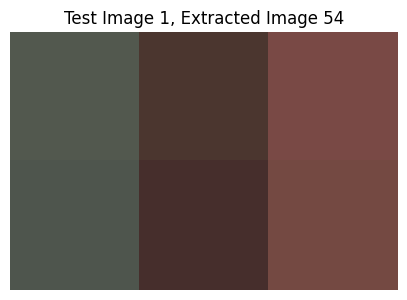

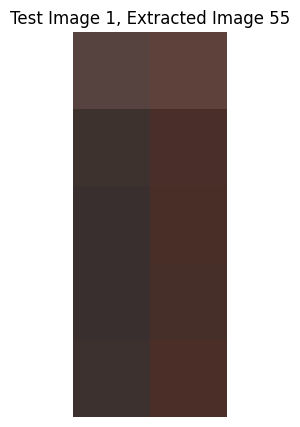

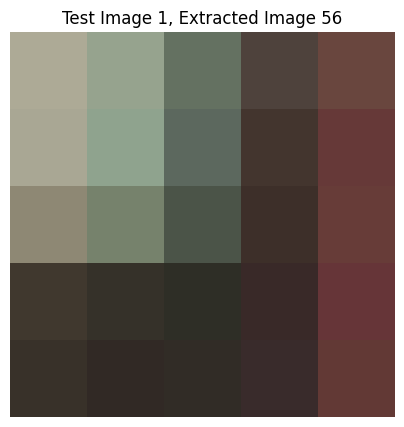

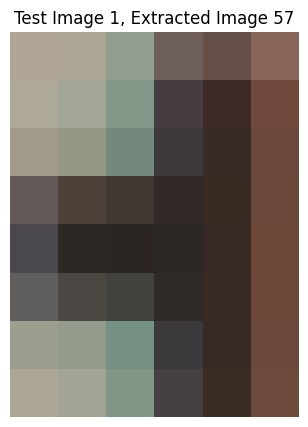

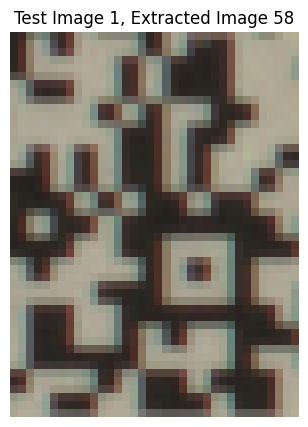

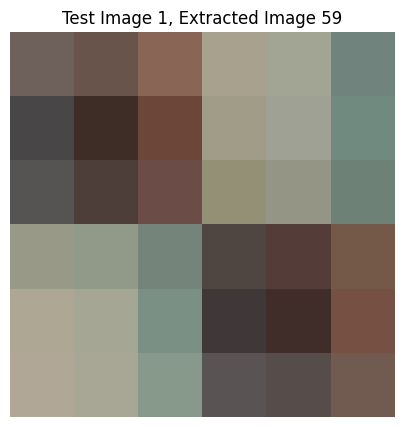

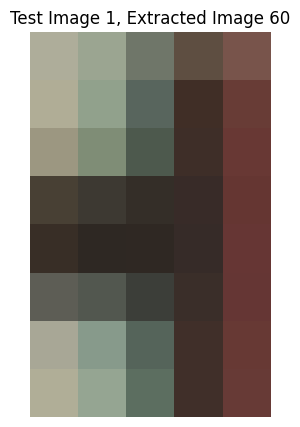

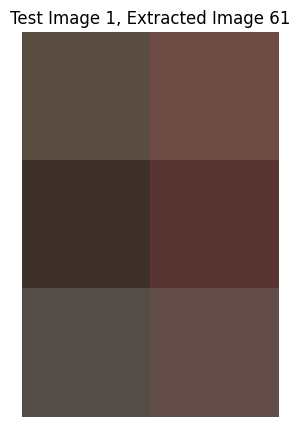

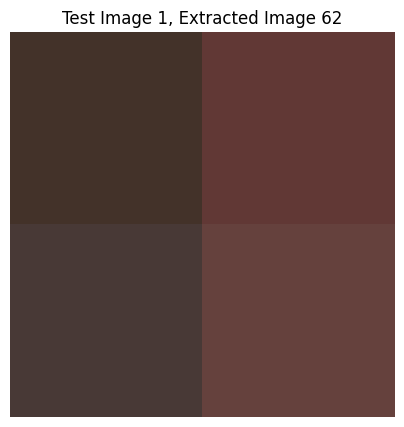

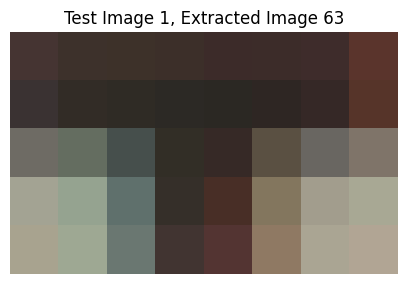

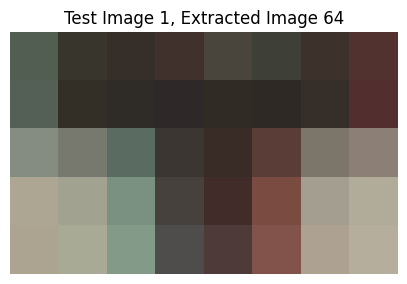

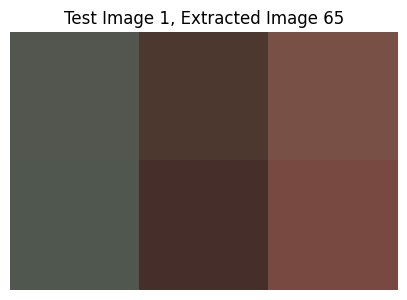

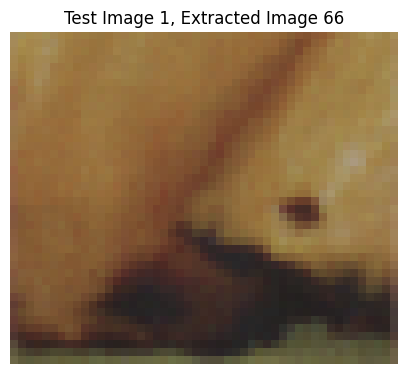

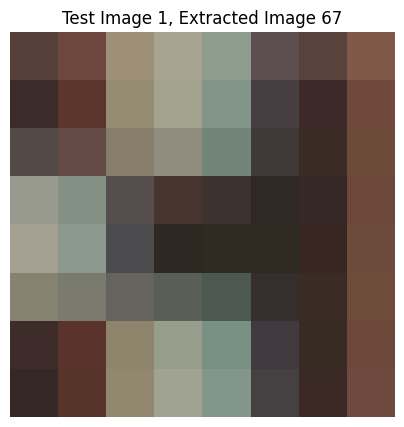

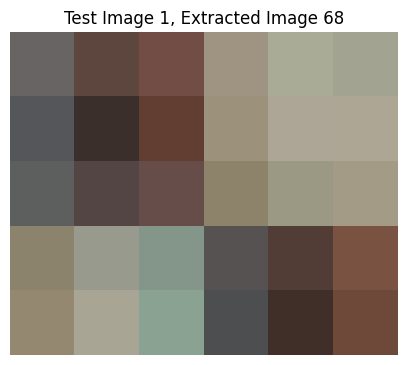

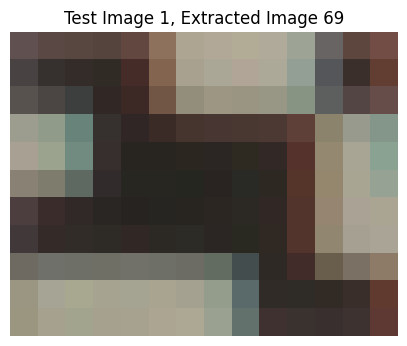

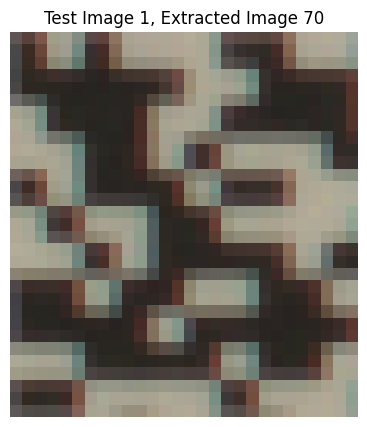

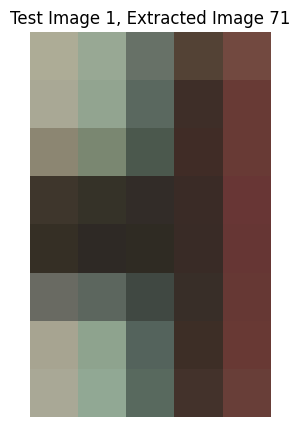

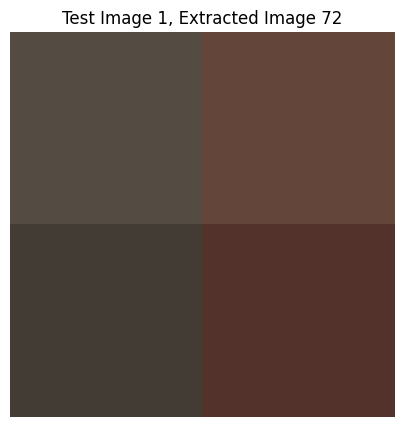

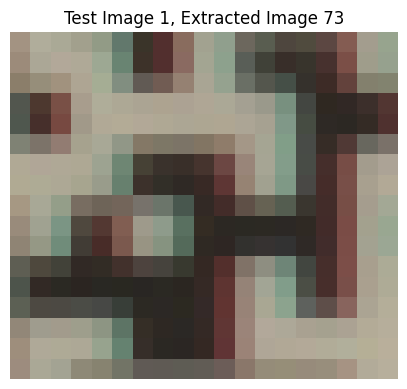

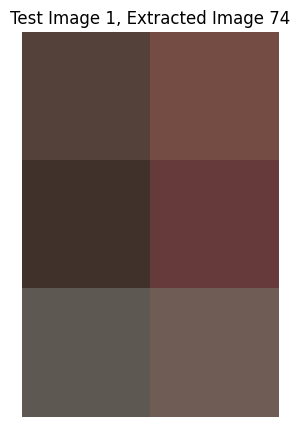

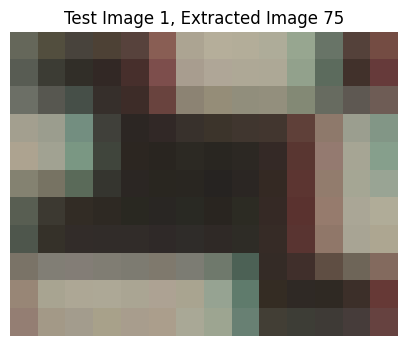

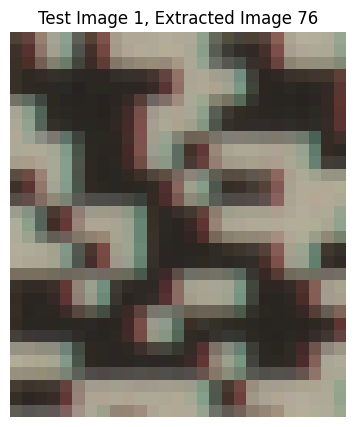

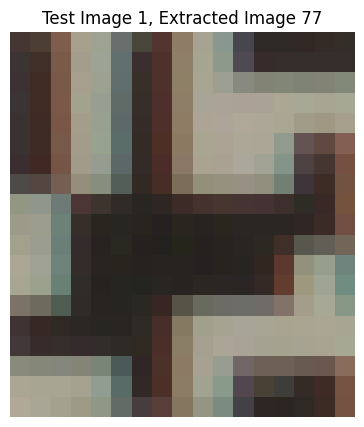

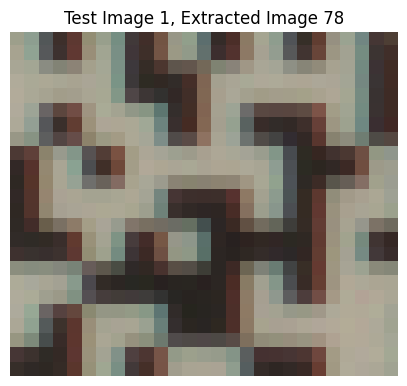

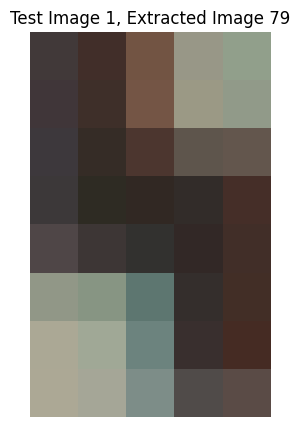

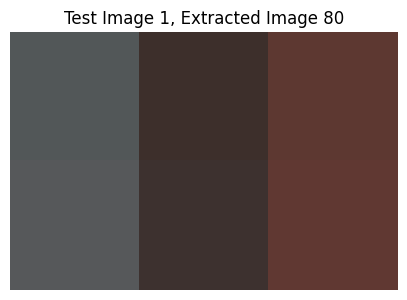

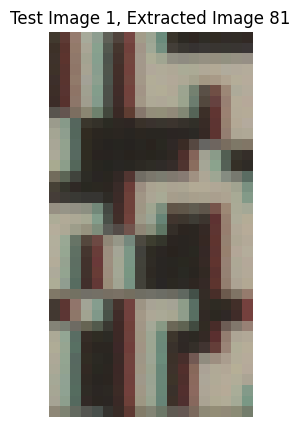

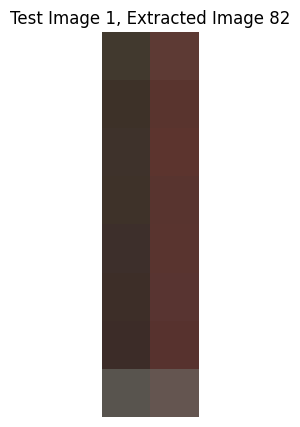

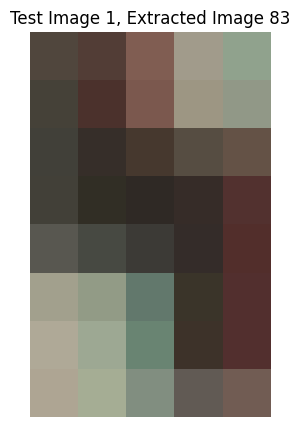

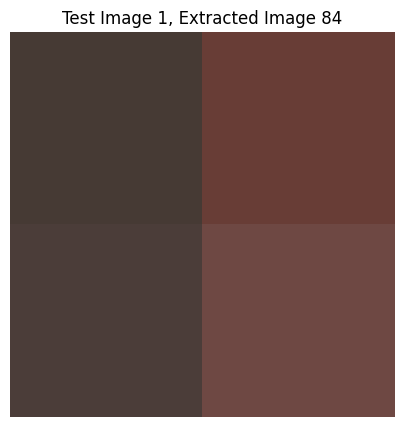

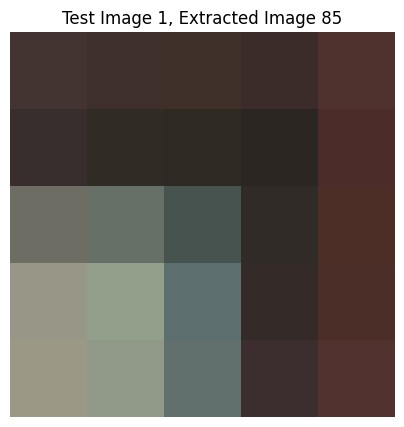

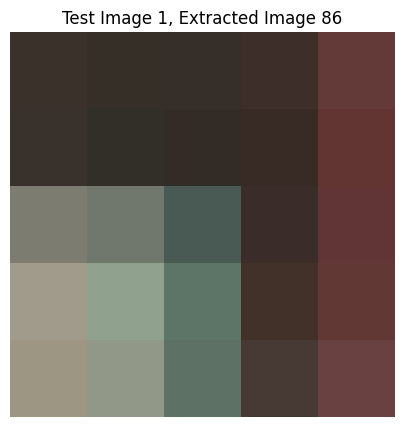

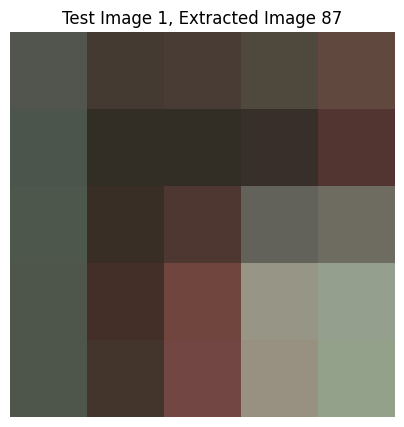

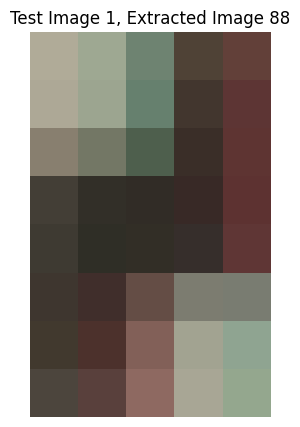

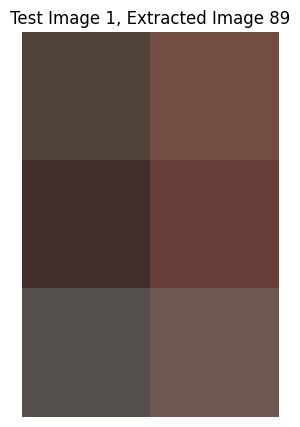

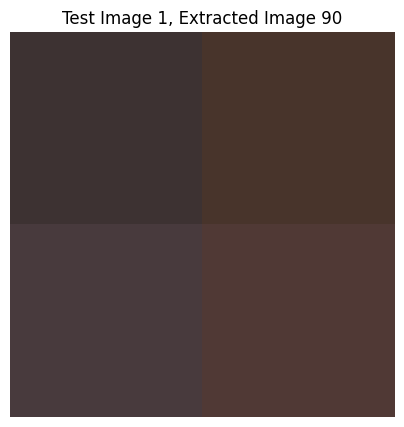

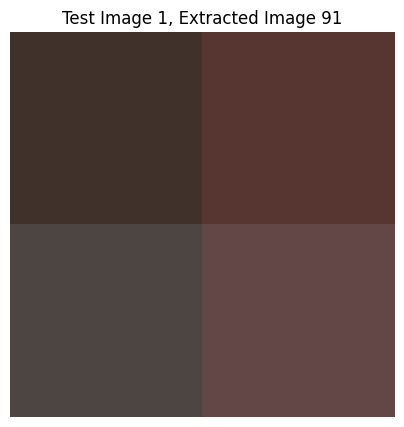

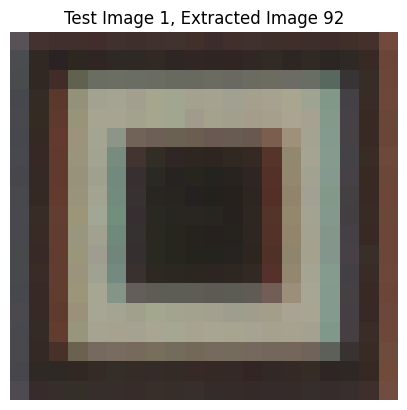

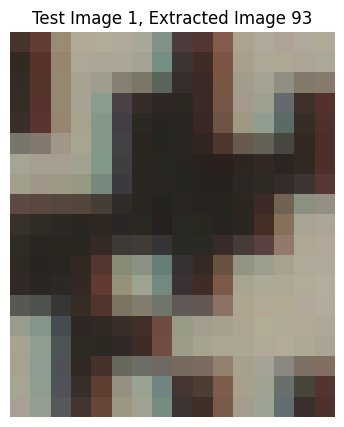

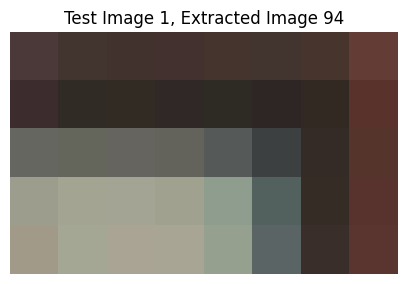

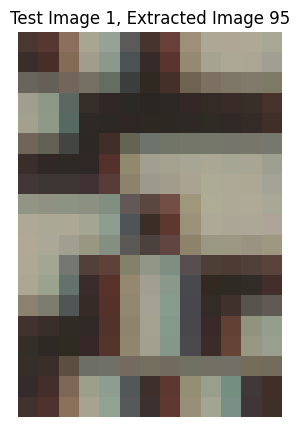

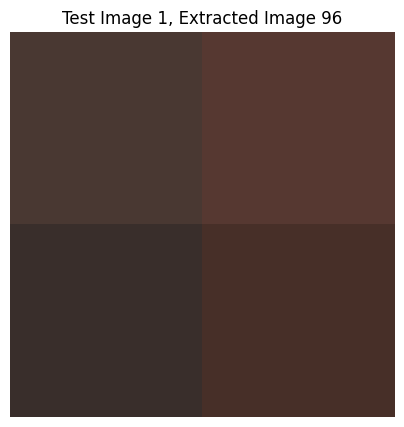

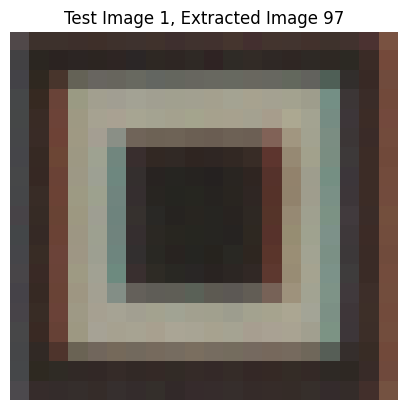

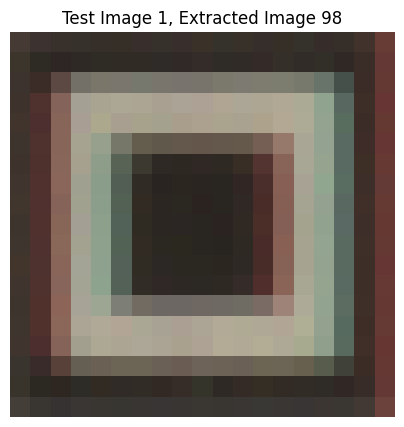

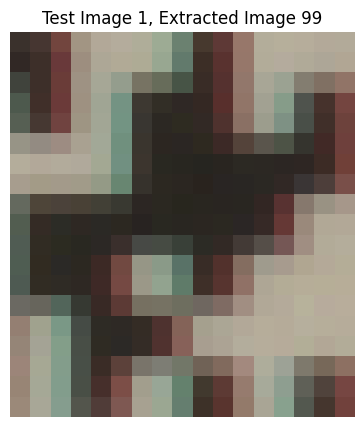

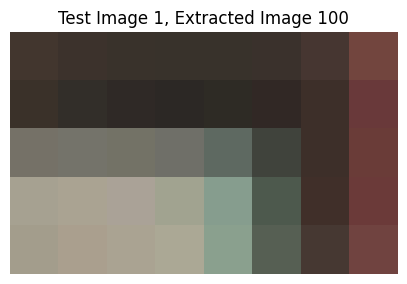

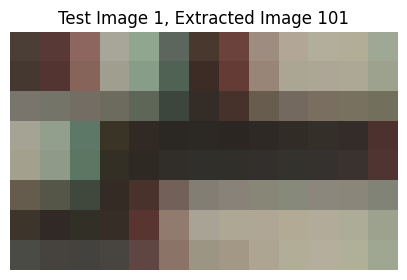

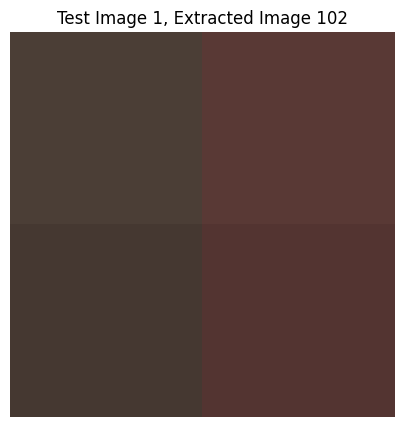

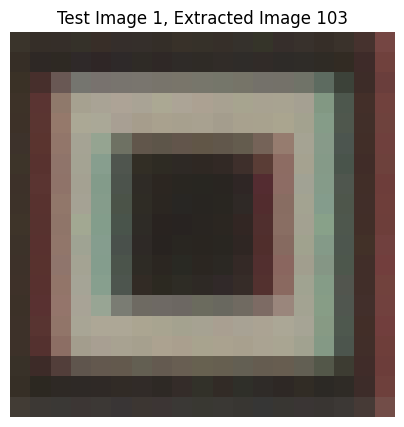

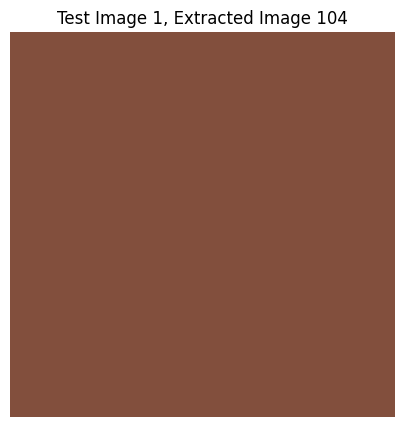

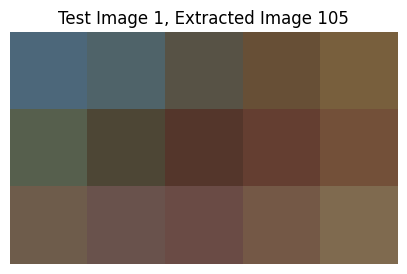

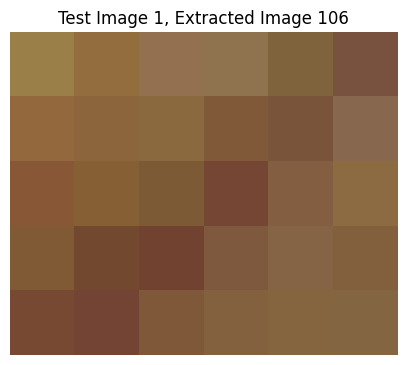

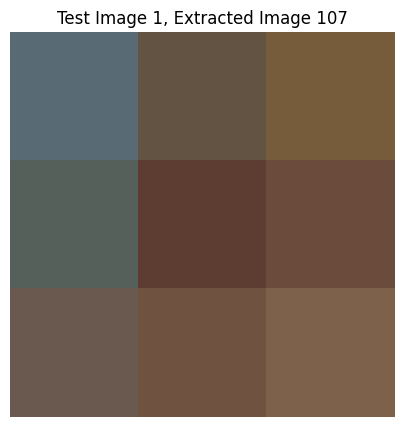

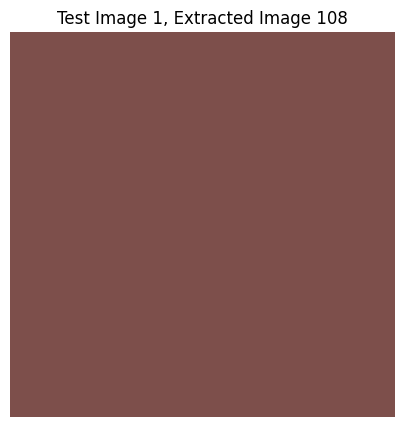

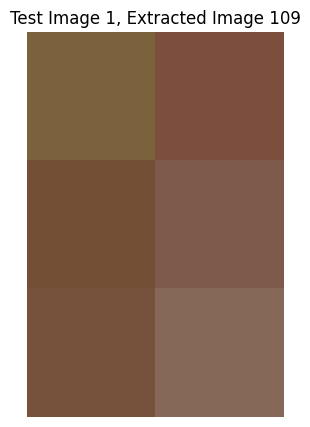

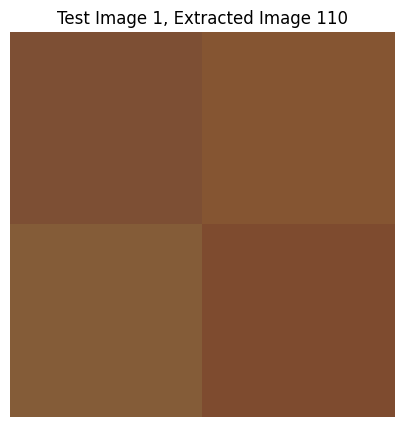

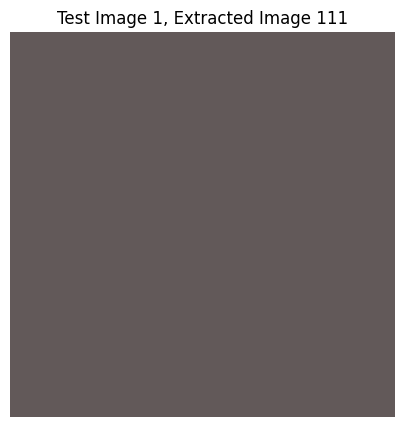

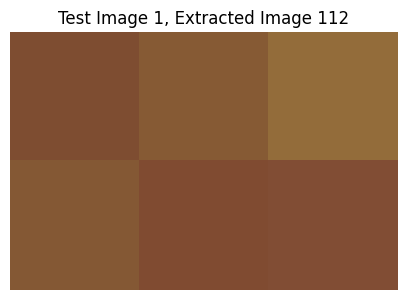

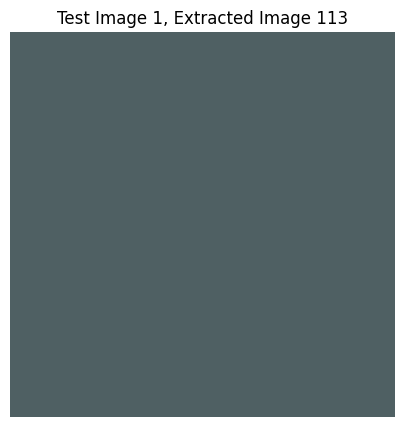

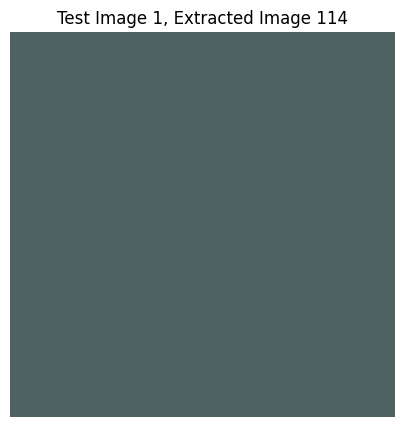

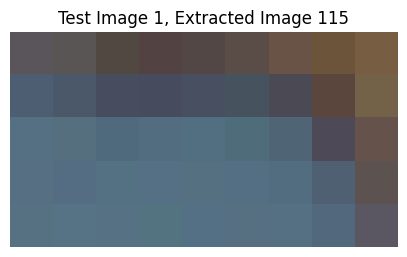

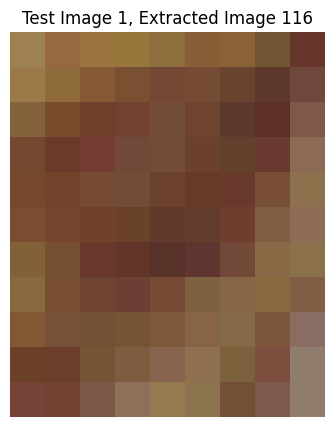

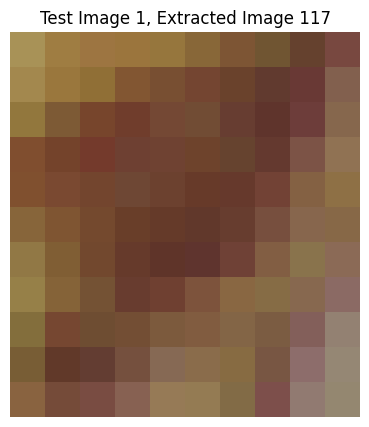

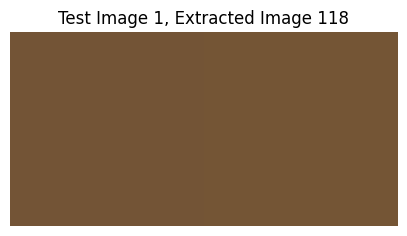

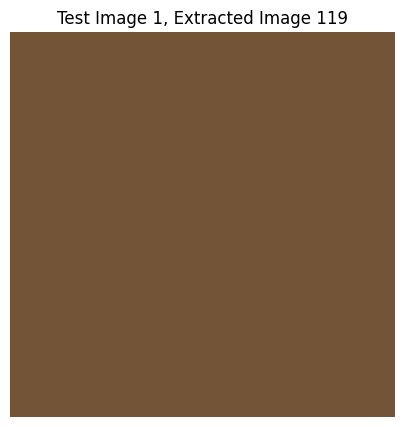

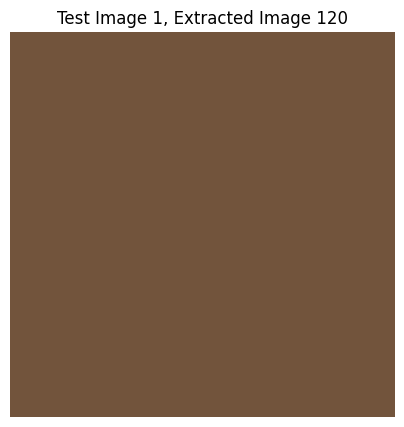

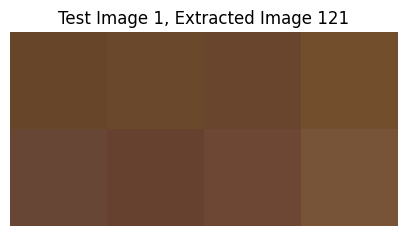

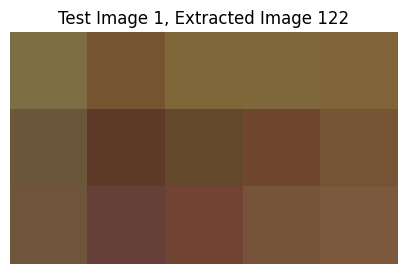

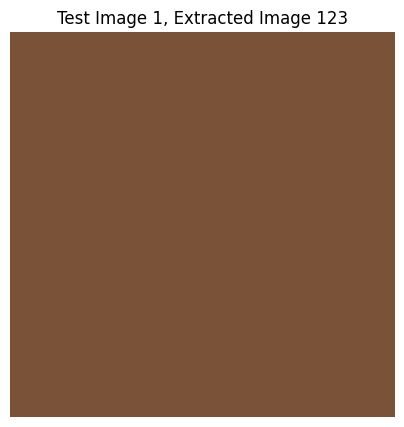

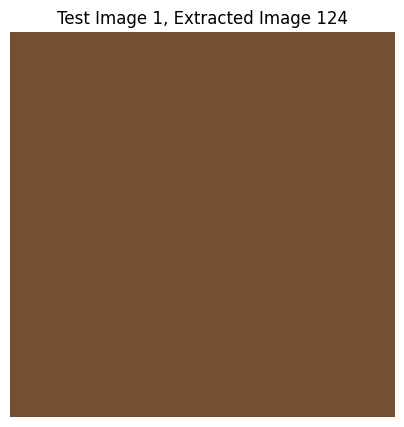

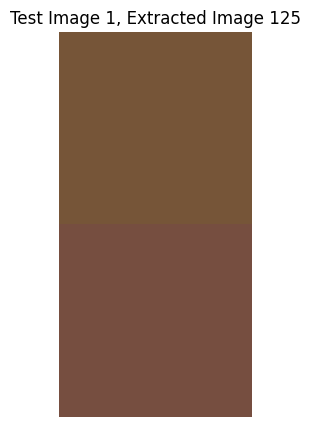

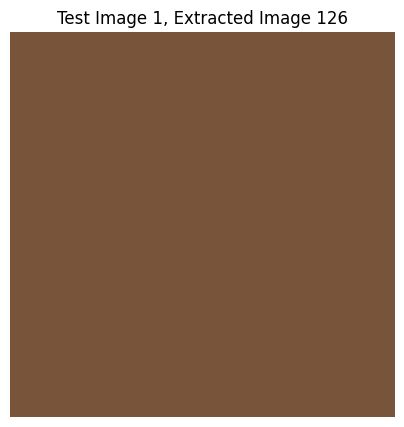

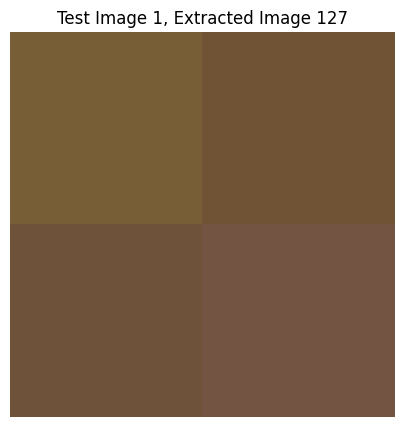

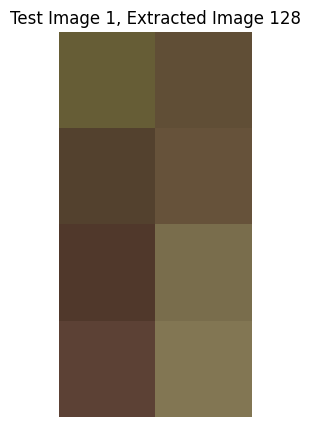

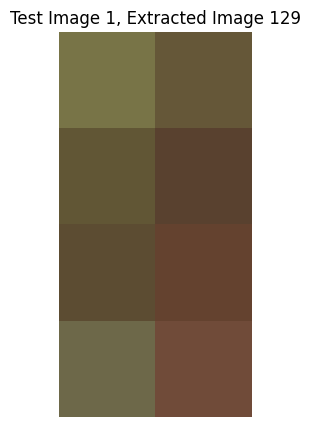

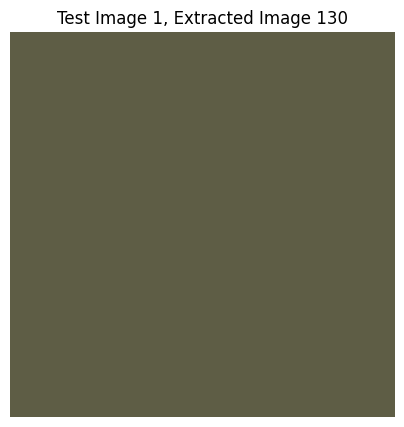

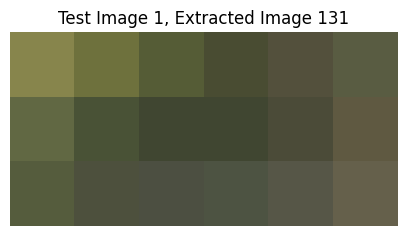

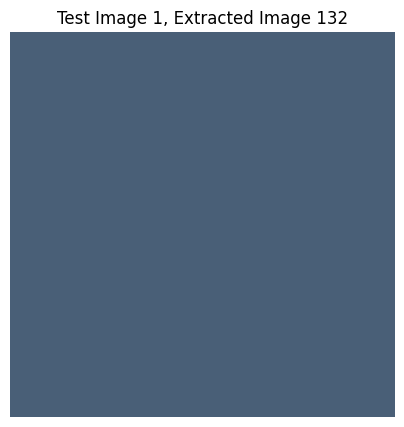

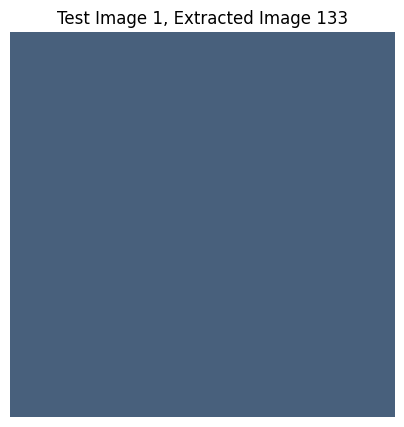

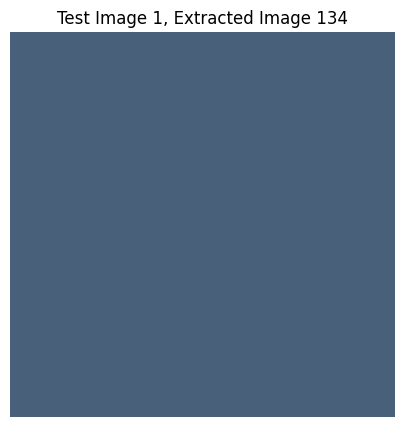

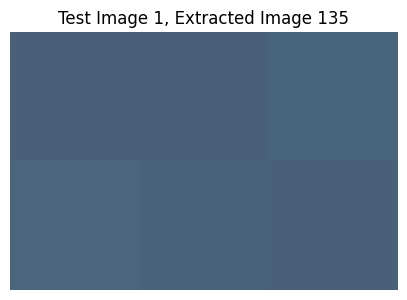

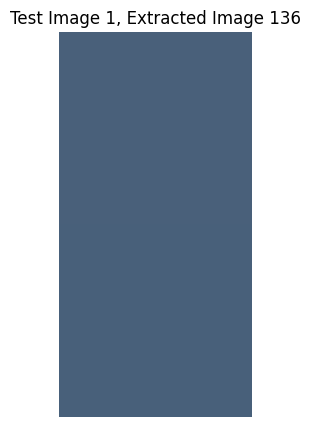

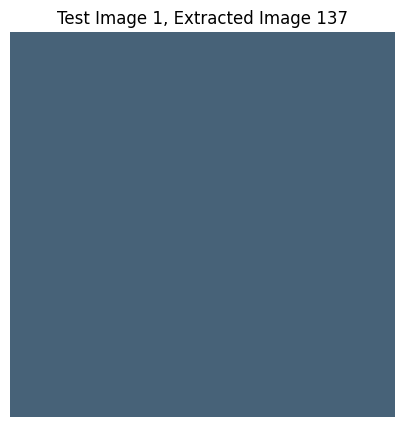

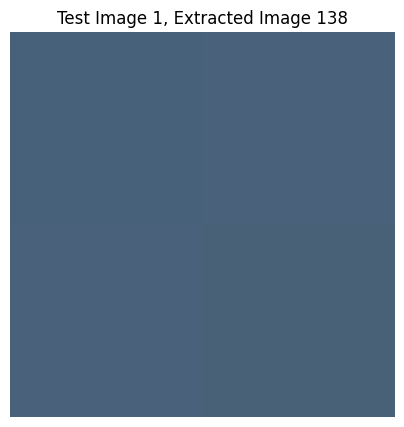

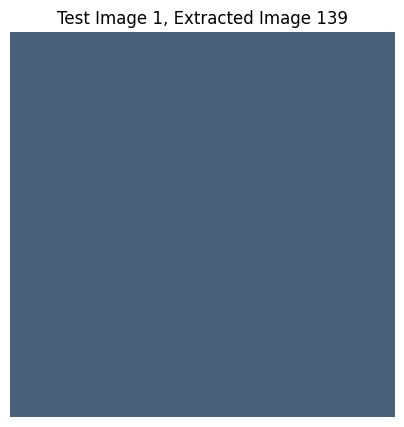

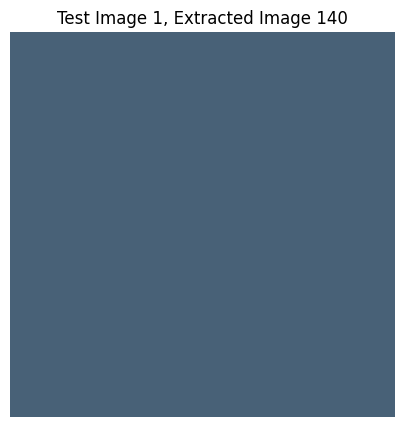

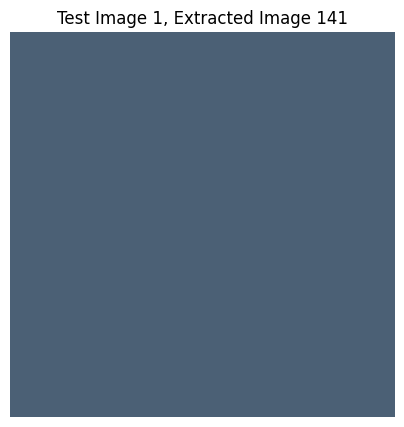

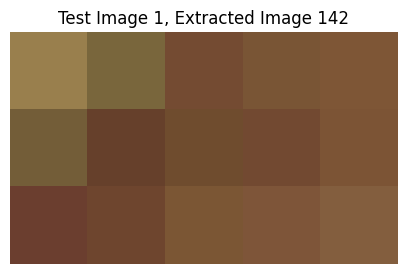

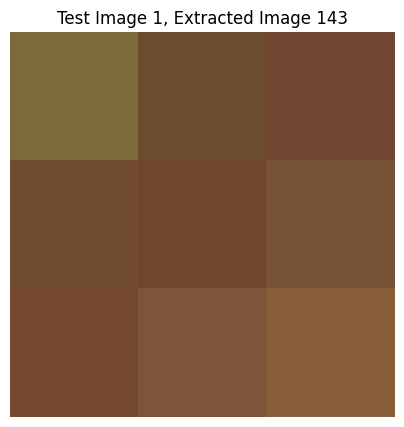

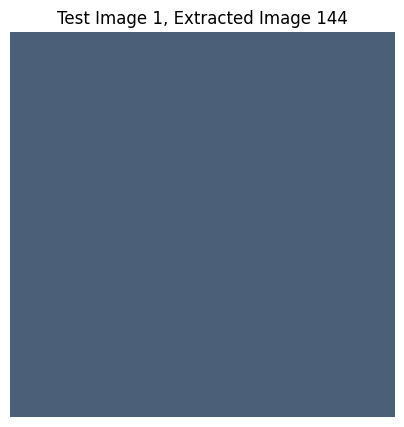

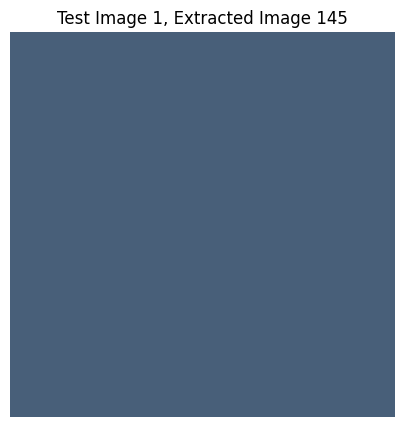

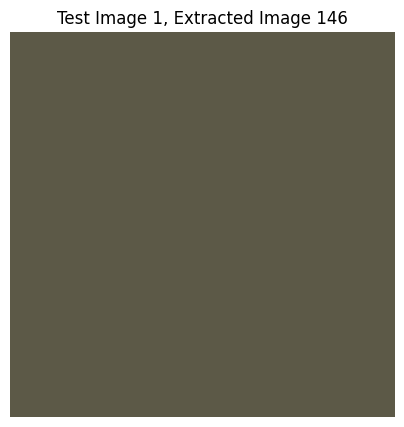

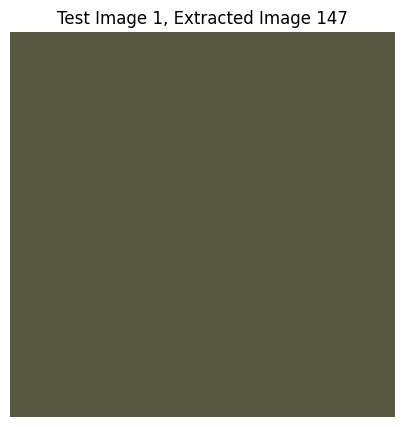

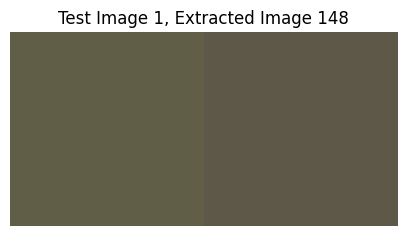

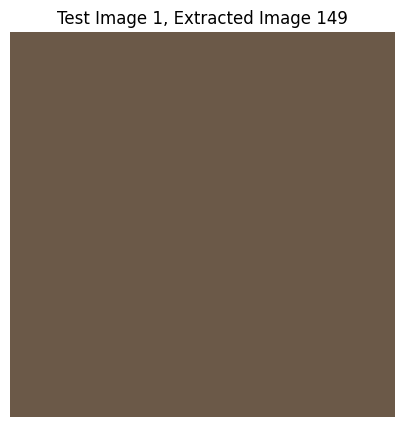

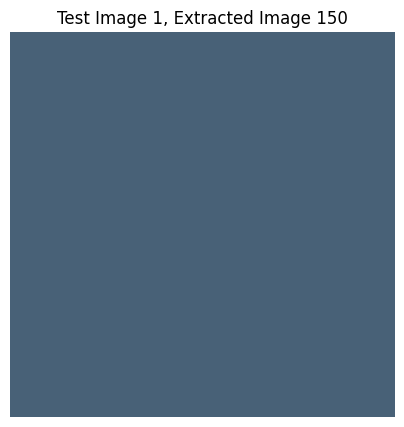

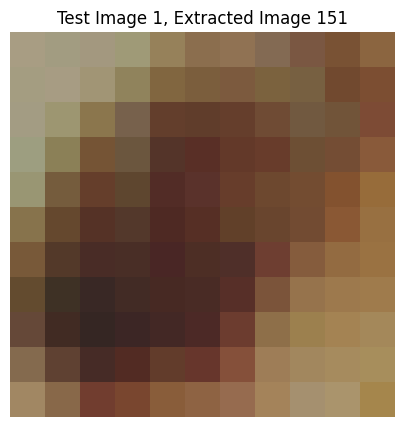

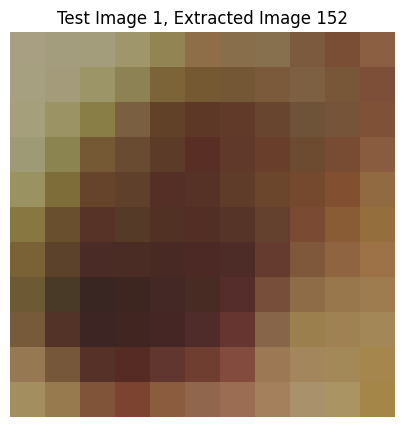

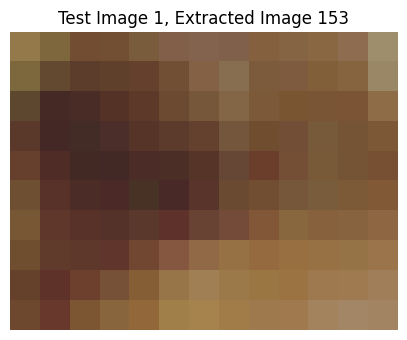

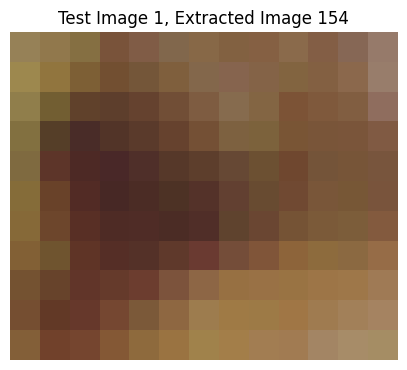

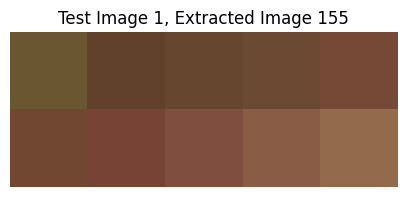

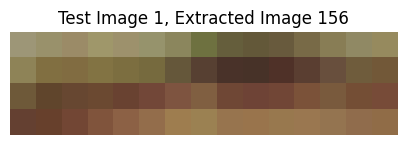

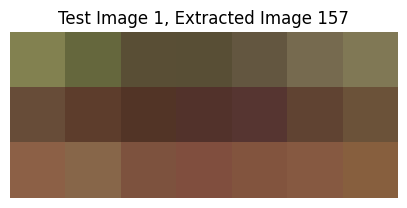

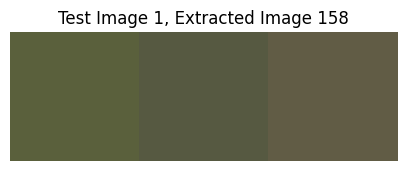

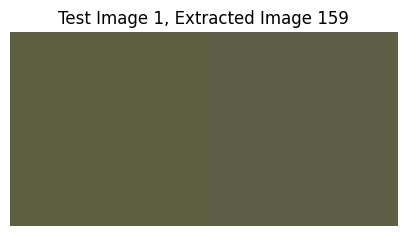

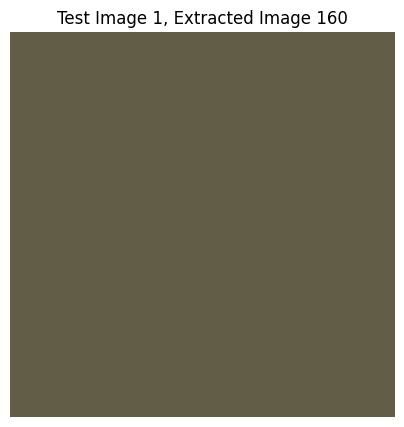

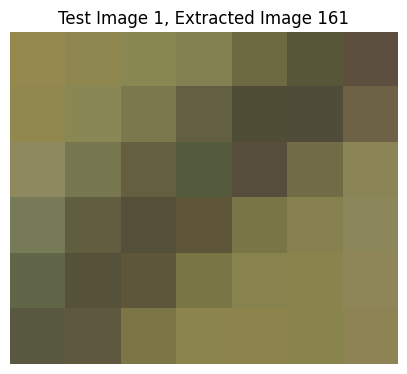

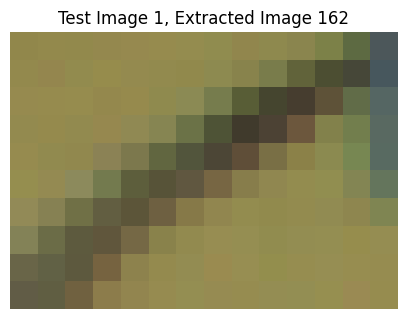

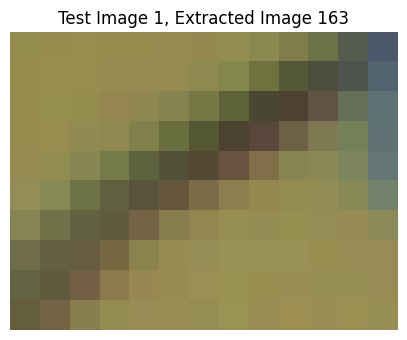

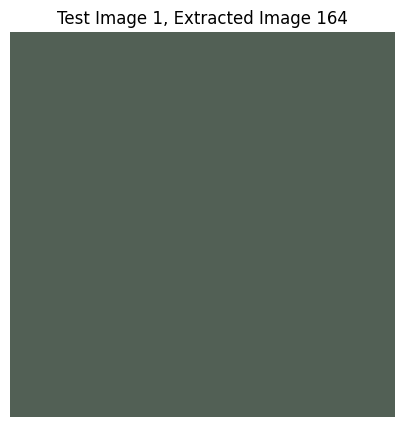

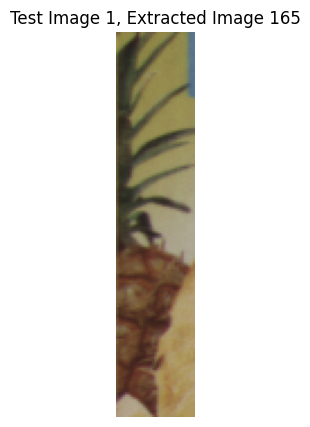

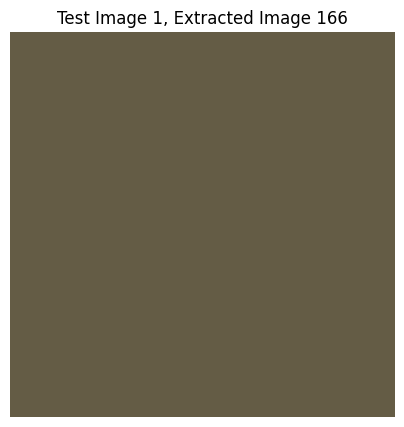

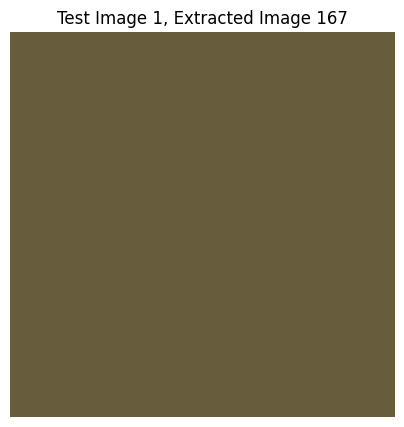

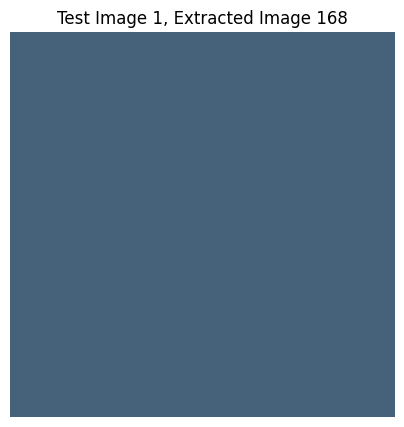

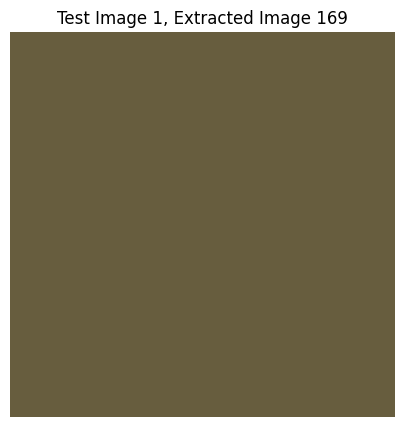

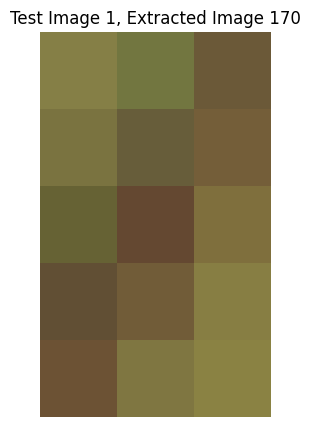

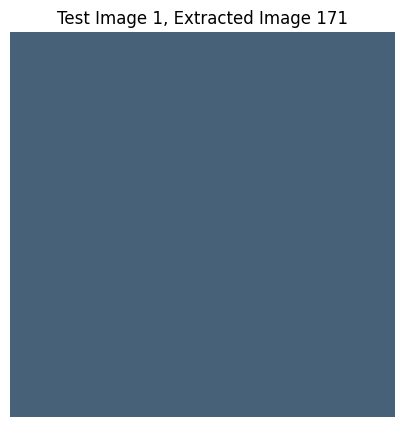

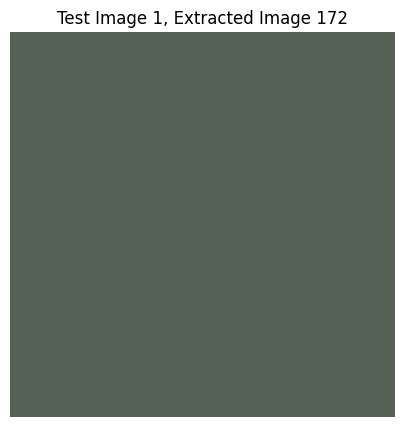

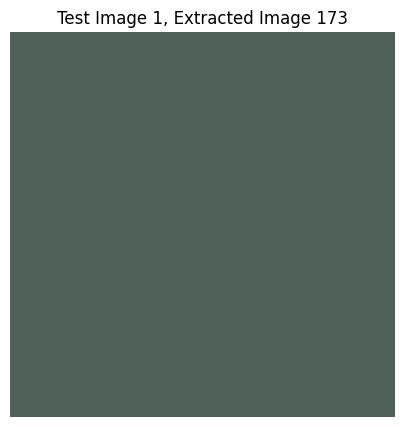

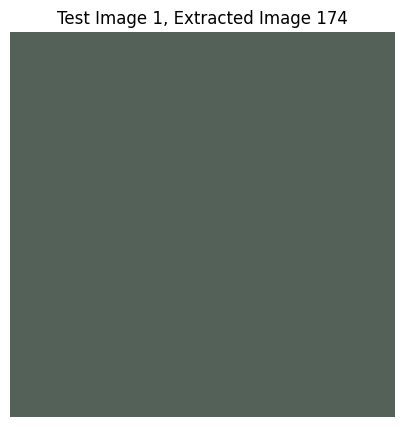

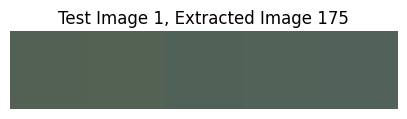

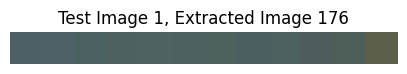

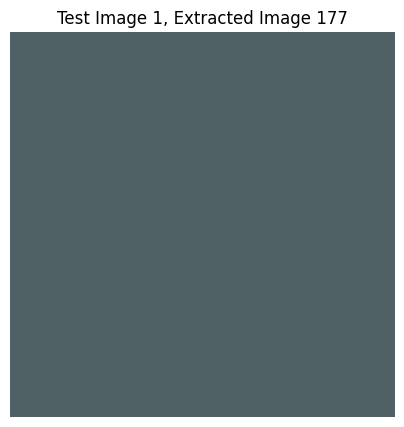

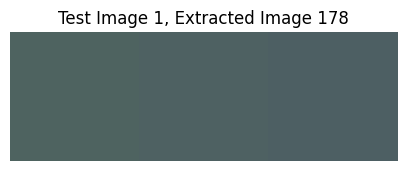

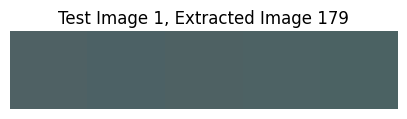

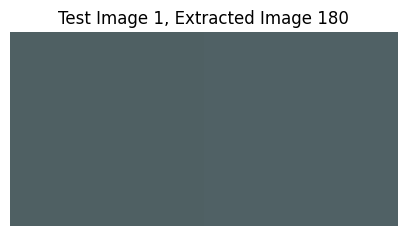

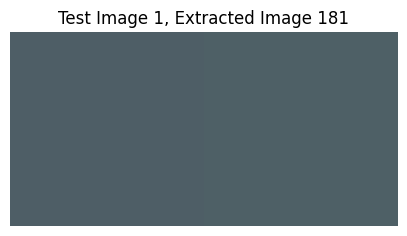

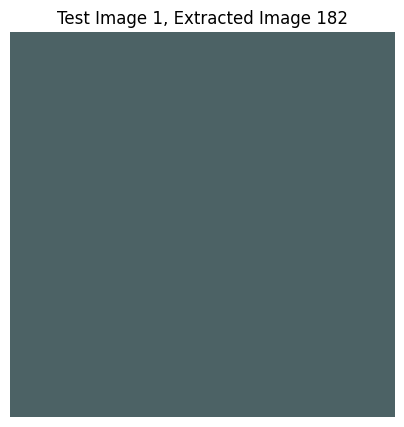

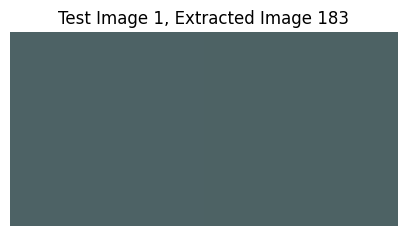

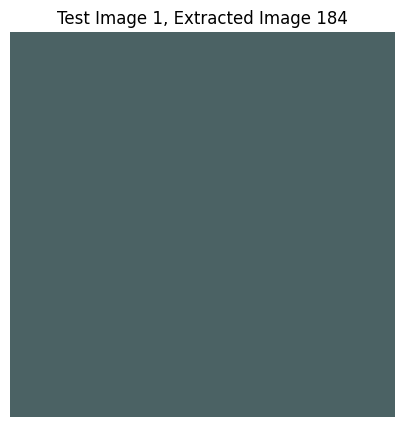

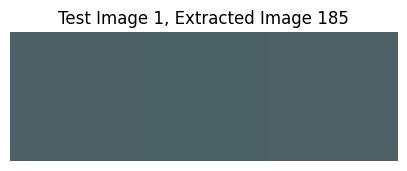

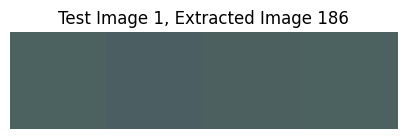

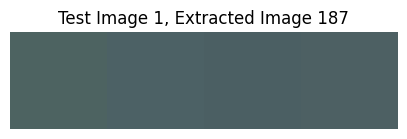

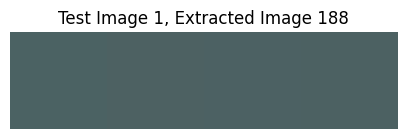

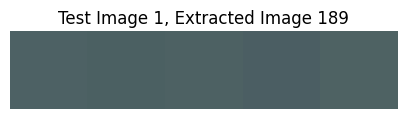

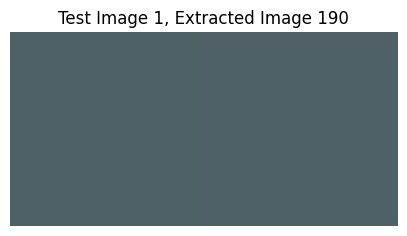

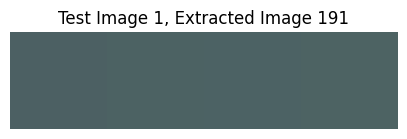

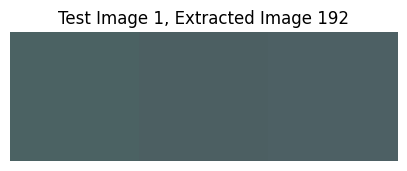

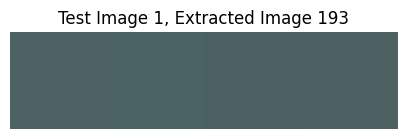

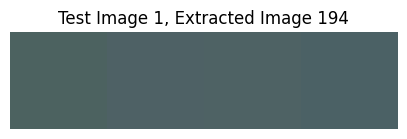

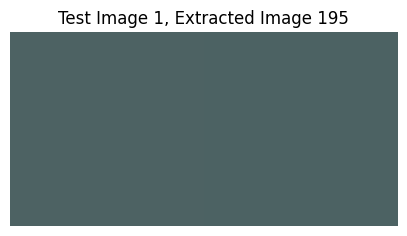

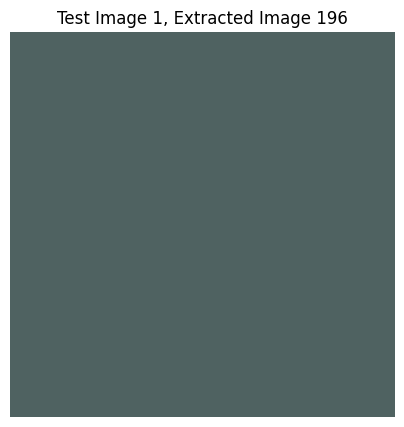

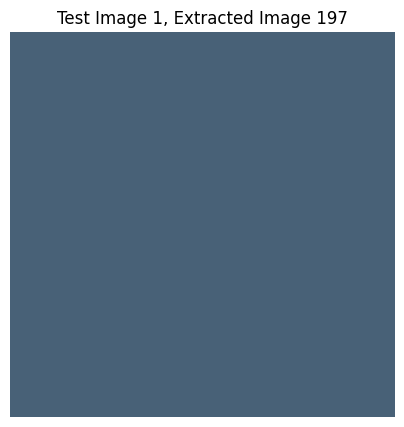

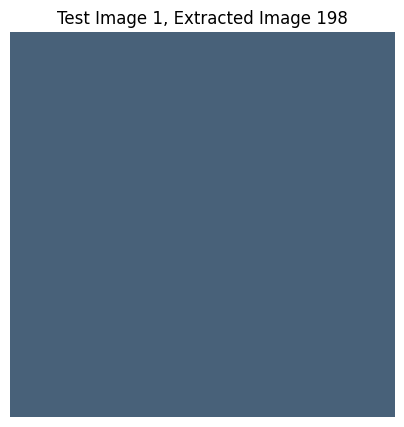

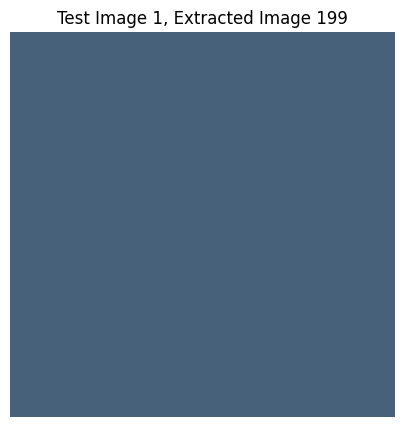

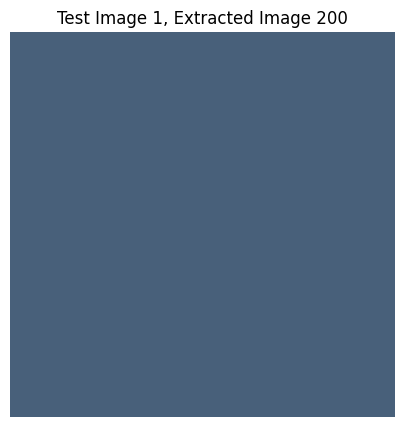

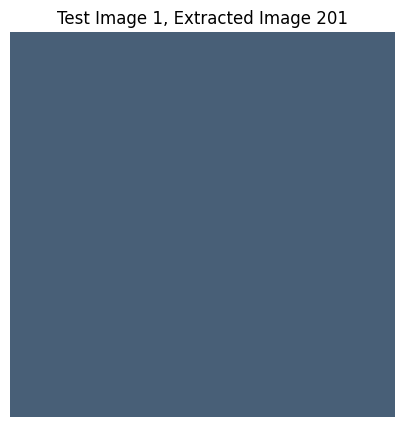

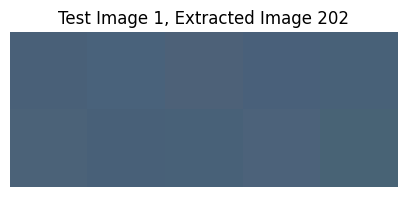

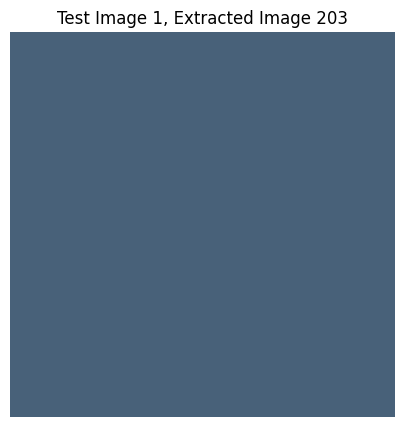

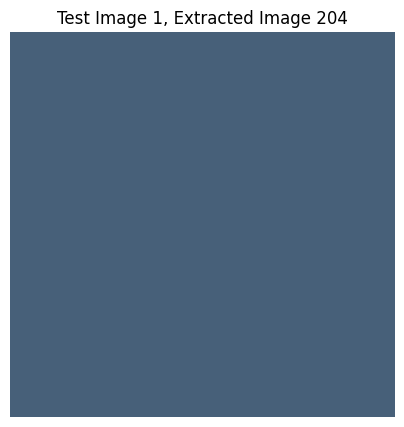

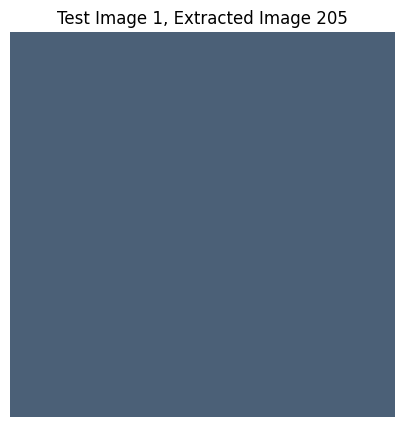

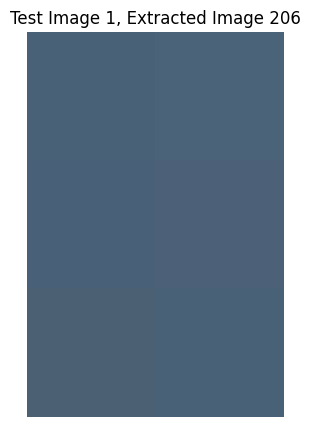

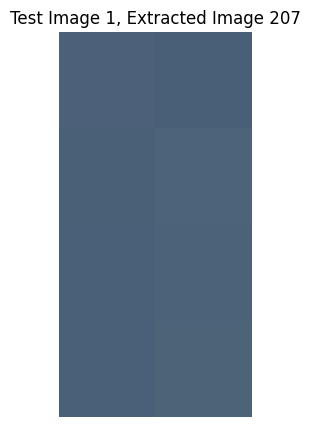

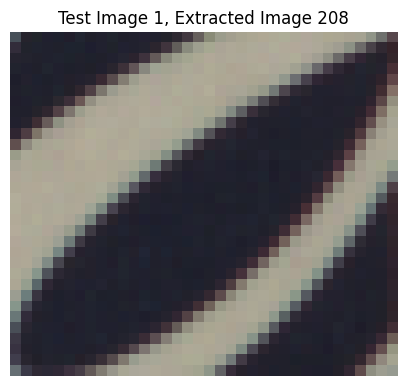

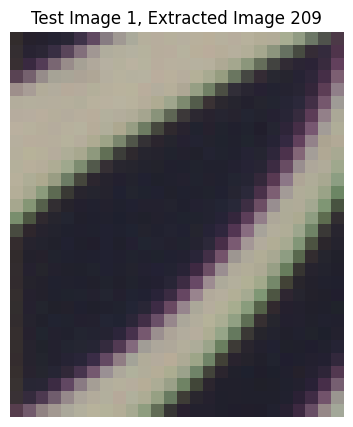

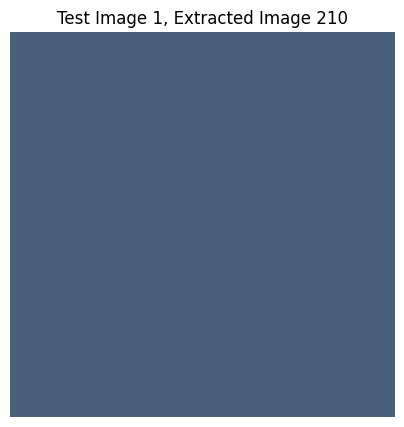

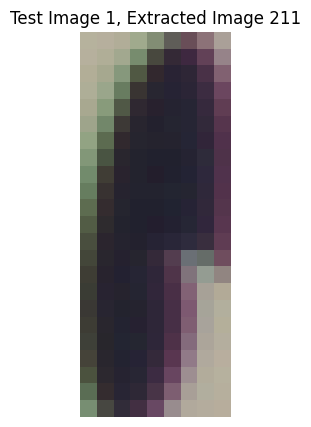

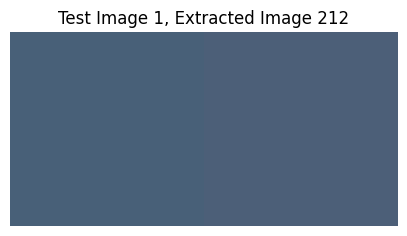

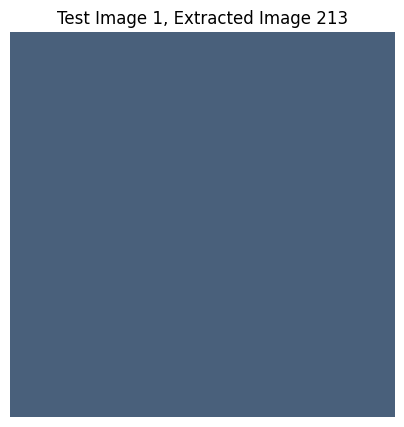

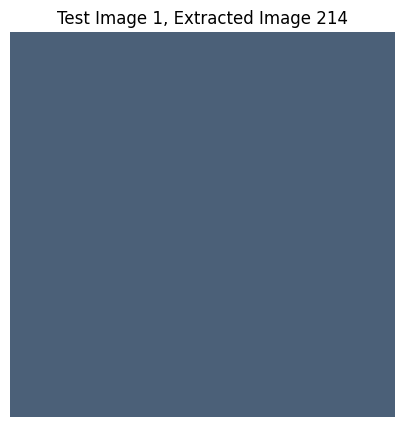

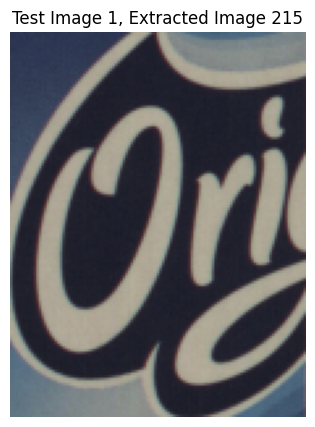

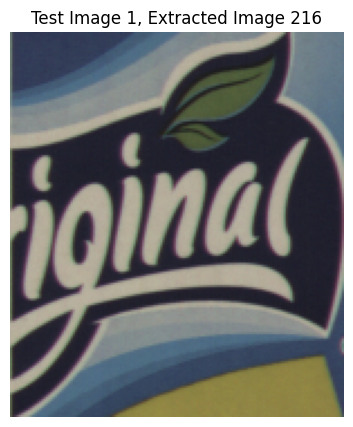

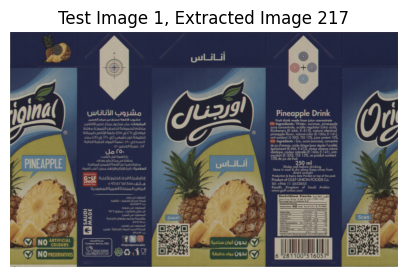

In [36]:
import cv2
import matplotlib.pyplot as plt

def extract_images_from_bounding_boxes_all(images):
    all_extracted_images = []  # 2D Array to store extracted images for each test image
    
    for image in images:
        extracted_images_for_current_test = []  # Array to store extracted images for the current test image
        
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Binarize the image
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Extract images encapsulated by the bounding boxes
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Extract the image enclosed by the bounding box
            extracted_image = image[y:y+h, x:x+w]
            extracted_images_for_current_test.append(extracted_image)
        
        all_extracted_images.append(extracted_images_for_current_test)
    
    return all_extracted_images

# Assuming you have a list of images called test_images
# Extract images encapsulated by the bounding boxes in all test images
all_extracted_images = extract_images_from_bounding_boxes_all(test_images)

# # Display each extracted image within Jupyter notebook for each test image
# for test_idx, extracted_images_for_test in enumerate(all_extracted_images):
#     for img_idx, extracted_image in enumerate(extracted_images_for_test):
#         plt.figure(figsize=(5,5))  # Set figure size
#         plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
#         plt.title(f'Test Image {test_idx + 1}, Extracted Image {img_idx + 1}')
#         plt.axis('off')  # Hide axis
#         plt.show()

# Display each extracted defect image within Jupyter notebook for the first test image
extracted_images_for_first_test = all_extracted_images[0]
for img_idx, extracted_image in enumerate(extracted_images_for_first_test):
    plt.figure(figsize=(5,5))  # Set figure size
    plt.imshow(cv2.cvtColor(extracted_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Test Image 1, Extracted Image {img_idx + 1}')
    plt.axis('off')  # Hide axis
    plt.show()



In [34]:
print(all_extracted_images)

NameError: name 'all_extracted_images' is not defined

In [37]:
import os
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image

# Organize dataset based on naming convention
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        label = 1 if self.image_files[idx].startswith("Y") else 0

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a dataset instance
root_dir = "/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data"  # Change this to your extracted data path
dataset = CustomDataset(root_dir=root_dir, transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained model and modify the final layer
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  # We have 2 classes: Major and Minor

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in val_loader:
            scores = model(data)
            _, predicted = scores.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {100 * correct/total:.2f}%")

print("Training complete!")


/Users/omarelherraoui/opt/anaconda3/envs/pioneers/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/omarelherraoui/opt/anaconda3/envs/pioneers/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/omarelherraoui/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
24.0%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this li

UnidentifiedImageError: cannot identify image file '/Users/omarelherraoui/Documents/pioneers4.0/PioneersHackathon4.0/data/.DS_Store'

In [30]:
# Given array of rectangle areas

# Function to normalize the values in the array to range [0, 1]
def normalize(values):
    min_val = min(values)
    max_val = max(values)
    normalized_values = [(x - min_val) / (max_val - min_val) for x in values]
    return normalized_values

# Normalize the areas
normalized_areas = normalize(bounding_box_sizes)

# Function to classify normalized values based on the specified rules
def classify_defects(values):
    classifications = []
    for value in values:
        if value < 0.1:
            classifications.append("Not a defect")
        elif value < 0.6 and value > 0.1:
            classifications.append("Minor defect")
        else:
            classifications.append("Defect")
    return classifications

# Classify normalized areas
defect_classifications = classify_defects(normalized_areas)

# Print the normalized values and classifications
print("Normalized Areas:", normalized_areas)
print("Defect Classifications:", defect_classifications)

Normalized Areas: [0.0007954255093393926, 1.0, 0.000900808562300873, 7.218017326128789e-06, 1.5879638117483338e-05, 4.330810395677274e-06, 4.330810395677274e-06, 1.2992431187031821e-05, 4.330810395677274e-06, 7.218017326128789e-06, 5.630053514380456e-05, 4.330810395677274e-06, 0.007223791739989693, 7.795458712219093e-05, 0.0005471257133205622, 0.0005196972474812728, 3.320287970019243e-05, 0.9984567878956737, 0.958333273183189, 0.9987325161575318, 0.9956547535696705, 0.0, 1.443603465225758e-06, 1.443603465225758e-06, 0.0, 0.0, 0.00037100609056301976, 1.443603465225758e-06, 0.0, 1.443603465225758e-06, 1.443603465225758e-06, 0.0, 0.0, 0.0, 0.7417393400711119]
Defect Classifications: ['Not a defect', 'Defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Not a defect', 'Defect', 'Defect', 'Defect', 'Defect', 'Not

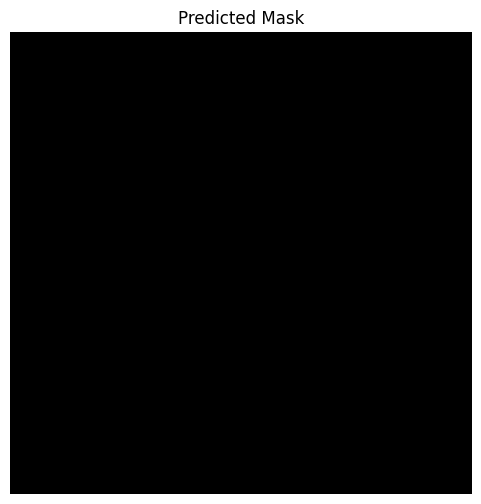

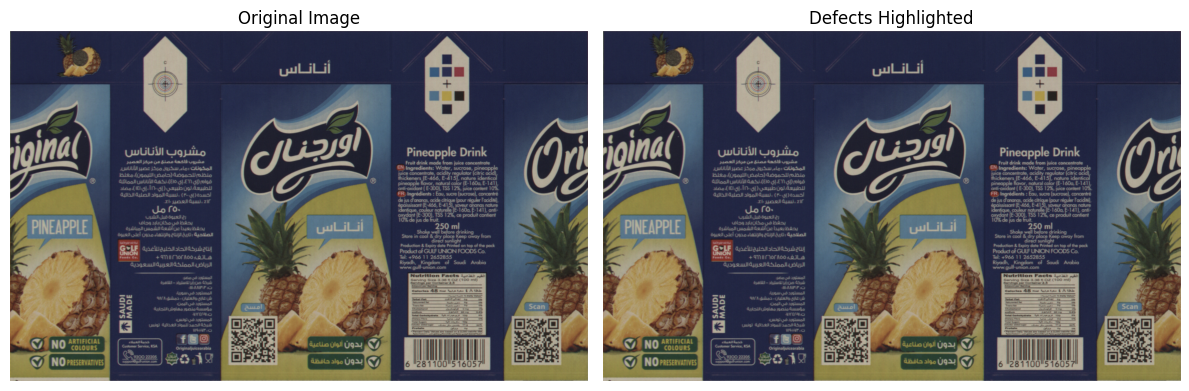

In [33]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np

# Load the pre-trained DeepLabV3+ model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
model.eval()

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# To compute the difference image
def compute_difference_image(reference, test):
    difference = cv2.absdiff(reference, test)
    return difference

def get_defect_mask(reference, test, model):
    difference = compute_difference_image(reference, test)
    with torch.no_grad():
        input_tensor = transform(difference).unsqueeze(0)
        output = model(input_tensor)
    probs, predictions = torch.max(output['out'].squeeze(), dim=0)
    mask = predictions.detach().cpu().numpy()
    
    # Exclude background class (class 0)
    mask_no_bg = np.where(mask == 0, 0, 1)
    
    return mask_no_bg

# Testing
# reference_image = cv2.imread('path_to_reference_image.jpg')
# test_image = cv2.imread('path_to_test_image.jpg')

mask = get_defect_mask(reference_images[3], test_images[3], model)

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

# Use the function to visualize defects
visualize_defects(test_images[1], mask)

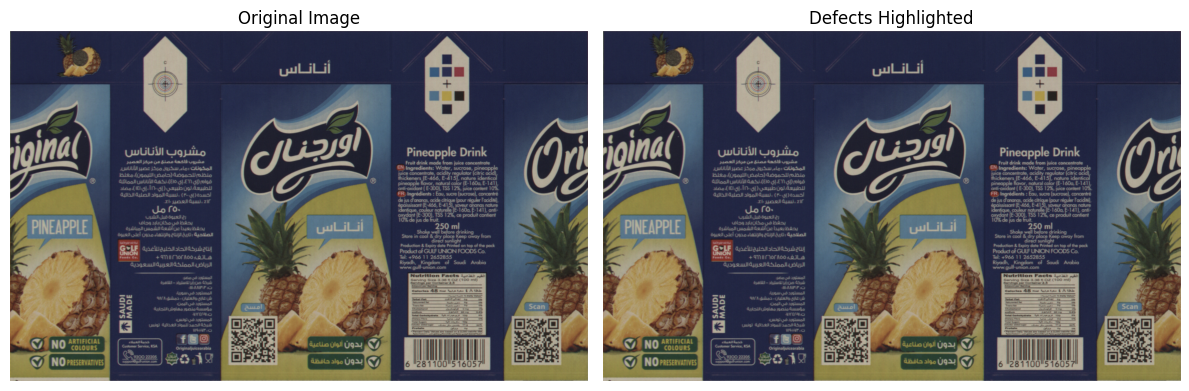

In [31]:
import matplotlib.pyplot as plt

def visualize_defects(test_image, mask):
    # Resize the mask to match the test image dimensions
    mask_resized = cv2.resize(mask.astype(np.uint8), (test_image.shape[1], test_image.shape[0]))
    
    # Convert the boolean mask back to a boolean type after resizing
    mask_resized = mask_resized.astype(bool)

    # Overlay the mask onto the test image (we'll use red color for defects)
    overlay = test_image.copy()
    overlay[mask_resized] = [0, 0, 255]  # Red color for defects

    # Display the original test image and the one with defects highlighted
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title('Defects Highlighted')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function to visualize defects
visualize_defects(test_images[1], mask)

